In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install pywavelets tqdm scikit-learn seaborn

In [ ]:
import numpy as np
import scipy.io as sio
import pywt
from scipy.signal import medfilt, resample
import matplotlib.pyplot as plt
from typing import Dict, List, Tuple, Optional, Any
import os
import glob
from tqdm import tqdm
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from multiprocessing import Pool, cpu_count
import random
import warnings
import gc
import joblib
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor
from itertools import product
import time
import json

In [ ]:
warnings.filterwarnings('ignore')

# Global debug flag
DEBUG_MODE = False

In [ ]:
mat_dir = '/content/drive/MyDrive/BCI_Research_Week1/Datasets/AmericanKaggle/Patient_1'
patient_id = "Patient_1"

**What does sorted() do here?**

    sorted() sorts the list alphabetically by file path/name.
**What does glob.glob() do?**

    glob.glob(pattern) returns a list of all files/directories in your filesystem that match the pattern (using Unix shell-style wildcards like *, ?, etc).

    The list contains full file paths (relative or absolute, depending on your pattern).
**Example**

Suppose you have a directory /data/ with these files:

Patient_1_interictal_segment_0003.mat

Patient_1_interictal_segment_0001.mat

Patient_1_interictal_segment_0002.mat

Patient_1_preictal_segment_0001.mat

interictal_file list will look like:
   *
```
[
  "/content/drive/MyDrive/Dataset/Dog_4_interictal_segment_0001.mat",
  "/content/drive/MyDrive/Dataset/Dog_4_interictal_segment_0002.mat",
  ...
]



In [ ]:
interictal_files = sorted(glob.glob(os.path.join(mat_dir, f"{patient_id}_interictal_segment_*.mat")))
preictal_files = sorted(glob.glob(os.path.join(mat_dir, f"{patient_id}_preictal_segment_*.mat")))

print(f"Found {len(interictal_files)} interictal files")
print(f"Found {len(preictal_files)} preictal files")

Found 50 interictal files
Found 18 preictal files


**What does basename() do ?**

f = "/content/drive/MyDrive/BCI_Research_Week1/Datasets/Article1_IntracranialEEG/Patient_1/"

gets the basename of a dir
so ouput here would be : Patient_1


In [ ]:
print("\nFirst5 interictal files:")
for f in interictal_files[:5]:
  print(f" {os.path.basename(f)}")

print("\nFirst 5 preictal files:")
for f in preictal_files[:5]:
    print(f"  {os.path.basename(f)}")


First5 interictal files:
 Patient_1_interictal_segment_0001.mat
 Patient_1_interictal_segment_0002.mat
 Patient_1_interictal_segment_0003.mat
 Patient_1_interictal_segment_0004.mat
 Patient_1_interictal_segment_0005.mat

First 5 preictal files:
  Patient_1_preictal_segment_0001.mat
  Patient_1_preictal_segment_0002.mat
  Patient_1_preictal_segment_0003.mat
  Patient_1_preictal_segment_0004.mat
  Patient_1_preictal_segment_0005.mat


#Refer to

###        Translating to .mat EEG Signals in Python

   ***in Python Syntax Relevant to Code Report***

In [ ]:
def inspect_mat(filepath : str):
  mat_data = sio.loadmat(filepath)
  print(mat_data)
inspect_mat(os.path.join(mat_dir,'Patient_1_interictal_segment_0002.mat'))

{'__header__': b'MATLAB 5.0 MAT-file, Platform: MACI64, Created on: Thu Aug 21 01:00:00 2014', '__version__': '1.0', '__globals__': [], 'interictal_segment_2': array([[(array([[ -220,  -219,  -218, ...,   158,   158,   158],
               [ -297,  -297,  -297, ...,     0,     1,     2],
               [ -253,  -253,  -253, ...,    -1,     0,    -1],
               ...,
               [ -578,  -578,  -578, ...,   382,   382,   380],
               [-1074, -1074, -1073, ...,   947,   947,   945],
               [ -651,  -653,  -655, ...,   358,   357,   355]], dtype=int16), array([[600]], dtype=uint16), array([[5000]], dtype=uint16), array([[array(['LD_1'], dtype='<U4'), array(['LD_3'], dtype='<U4'),
                array(['LD_4'], dtype='<U4'), array(['LD_5'], dtype='<U4'),
                array(['LD_6'], dtype='<U4'), array(['LD_7'], dtype='<U4'),
                array(['LD_8'], dtype='<U4'), array(['RD_1'], dtype='<U4'),
                array(['RD_2'], dtype='<U4'), array(['RD_3'], d

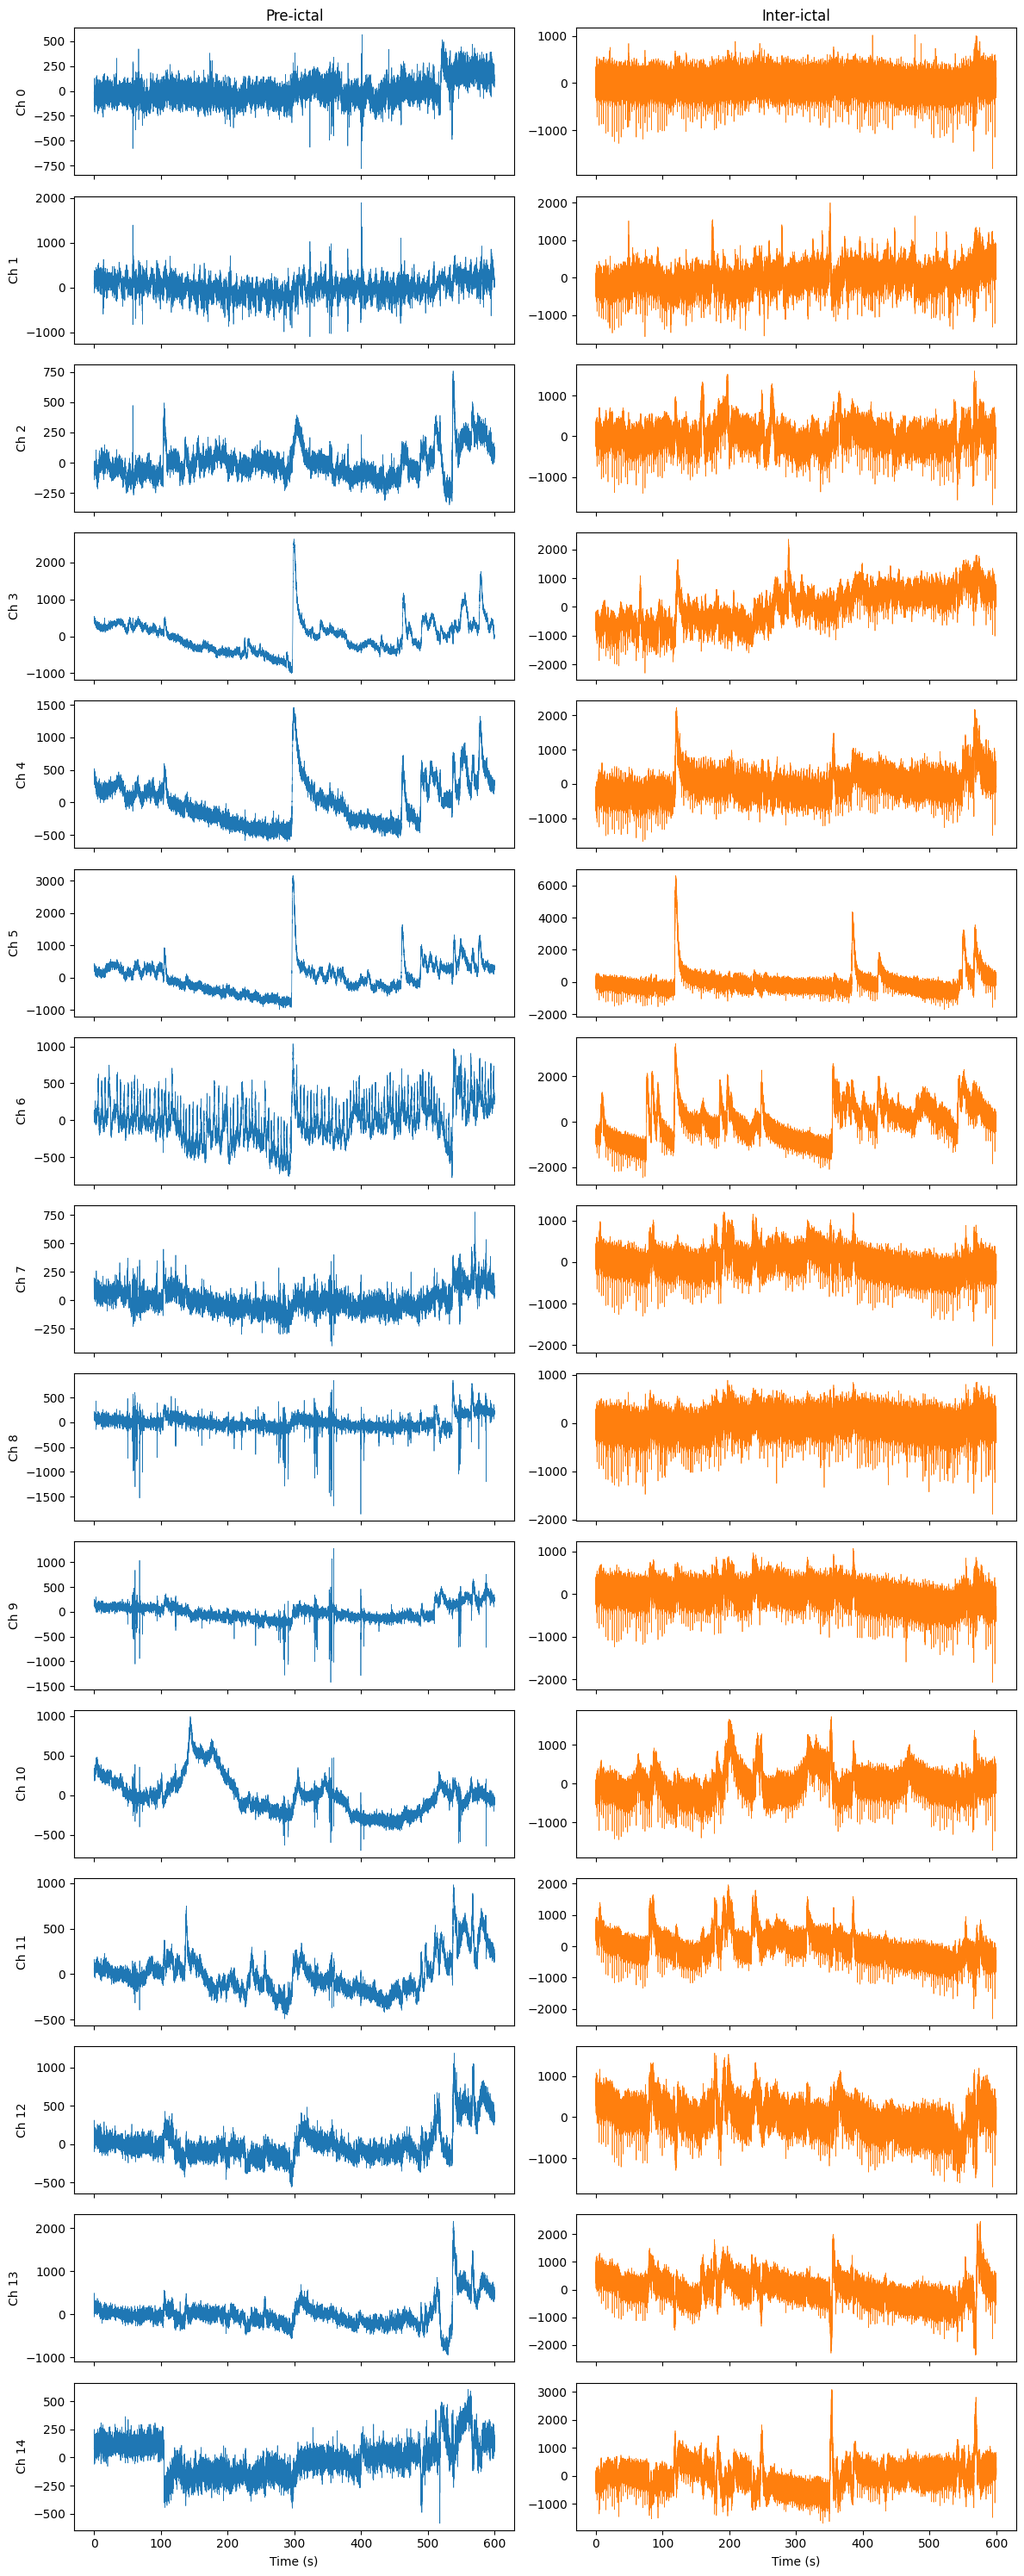

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.signal import decimate

# ─── SETTINGS ────────────────────────────────────────────────────────────────
target_fs   = 500   # down-sample to 500 Hz
pre_fn  = "Patient_1_preictal_segment_0017.mat"
int_fn  = "Patient_1_interictal_segment_0017.mat"

def load_segment(fn):
    data = loadmat(f"{mat_dir}/{fn}", struct_as_record=False, squeeze_me=True)
    key  = next(k for k in data if not k.startswith("__"))
    s    = data[key]
    sig  = s.data      # shape (n_ch, n_samps)
    fs   = float(s.sampling_frequency)
    # down‑sample each channel
    factor = int(round(fs/target_fs))
    return decimate(sig, factor, axis=1, zero_phase=True), target_fs

# load & down‑sample
pre_sig,  fs_ds = load_segment(pre_fn)
int_sig,  fs_ds = load_segment(int_fn)
n_ch, n_samps  = pre_sig.shape
t = np.arange(n_samps)/fs_ds  # seconds

# ─── PLOT ───────────────────────────────────────────────────────────────────
fig, axes = plt.subplots(n_ch, 2, figsize=(12, 2*n_ch), sharex=True)
for ch in range(n_ch):
    axes[ch,0].plot(t, pre_sig[ch], lw=0.5)
    axes[ch,0].set_ylabel(f"Ch {ch}")
    if ch==0: axes[ch,0].set_title("Pre‑ictal")
    axes[ch,1].plot(t, int_sig[ch], lw=0.5, color='C1')
    if ch==0: axes[ch,1].set_title("Inter‑ictal")

axes[-1,0].set_xlabel("Time (s)")
axes[-1,1].set_xlabel("Time (s)")
fig.tight_layout()
plt.show()


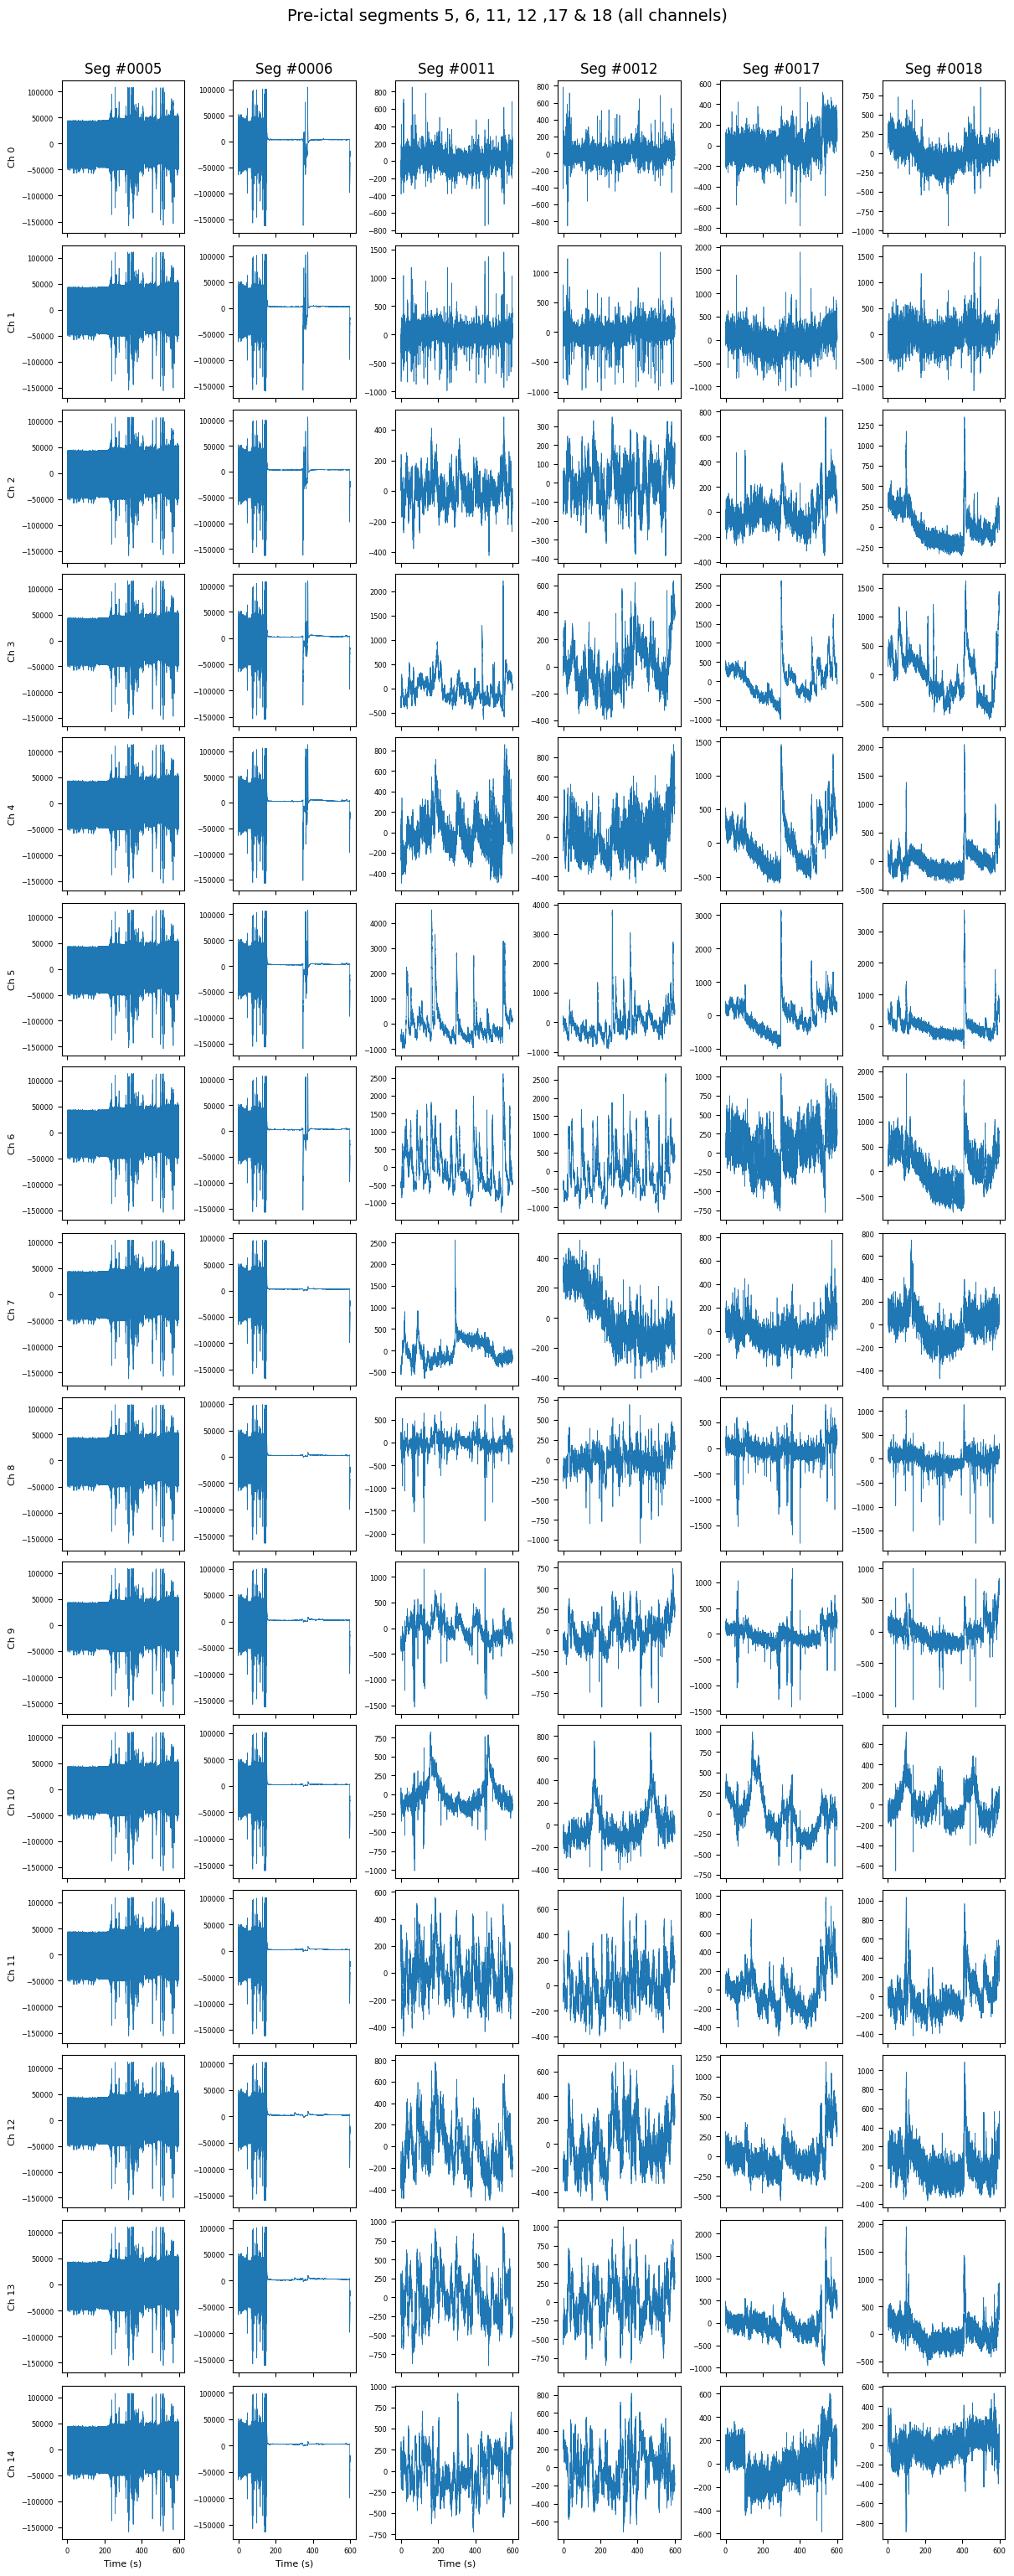

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.signal import decimate

# ─── SETTINGS ─────────────────────────────────────────────────────────────────
target_fs   = 500   # Hz after down‑sampling

# the three “sequence‑6” files for each of the 3 seizures:
seqs = ["0005","0006","0011", "0012","0017", "0018"]
files = []
for seq in seqs:
    fn = f"Patient_1_preictal_segment_{seq}.mat"
    path = os.path.join(mat_dir, fn)
    if os.path.exists(path):
        files.append(path)
    else:
        raise FileNotFoundError(f"Expected {fn} in {data_dir}")

# ─── LOAD & DOWNSAMPLE ALL THREE ──────────────────────────────────────────────
data_ds = []
for path in files:
    mat = loadmat(path, struct_as_record=False, squeeze_me=True)
    key = next(k for k in mat if not k.startswith("__"))
    s   = mat[key]
    eeg = s.data            # shape (n_ch, n_samps)
    fs  = float(s.sampling_frequency)

    factor = int(round(fs/target_fs))
    #Downsampled Signal down to sampling_frequency
    dsig   = decimate(eeg, factor, axis=1, zero_phase=True)
    data_ds.append(dsig)

# ─── PLOT GRID ────────────────────────────────────────────────────────────────
n_ch, n_samps = data_ds[0].shape
t = np.arange(n_samps) / target_fs

fig, axes = plt.subplots(n_ch, 6, figsize=(12, 2*n_ch), sharex=True, constrained_layout=True)
for col, dsig in enumerate(data_ds):
    for ch in range(n_ch):
        ax = axes[ch, col]
        # lw = linewidth = 0.5 so make the curve thin as to not seem as a block but see the curves
        ax.plot(t, dsig[ch], lw=0.5)
        if ch == 0:
            ax.set_title(f"Seg #{seqs[col]}", fontsize=12)
        if col == 0:
            ax.set_ylabel(f"Ch {ch}", fontsize=8)
        ax.tick_params(labelsize=6)

# common labels
axes[-1,0].set_xlabel("Time (s)", fontsize=8)
axes[-1,1].set_xlabel("Time (s)", fontsize=8)
axes[-1,2].set_xlabel("Time (s)", fontsize=8)
fig.suptitle("Pre‑ictal segments 5, 6, 11, 12 ,17 & 18 (all channels)", fontsize=14, y=1.02)
plt.show()


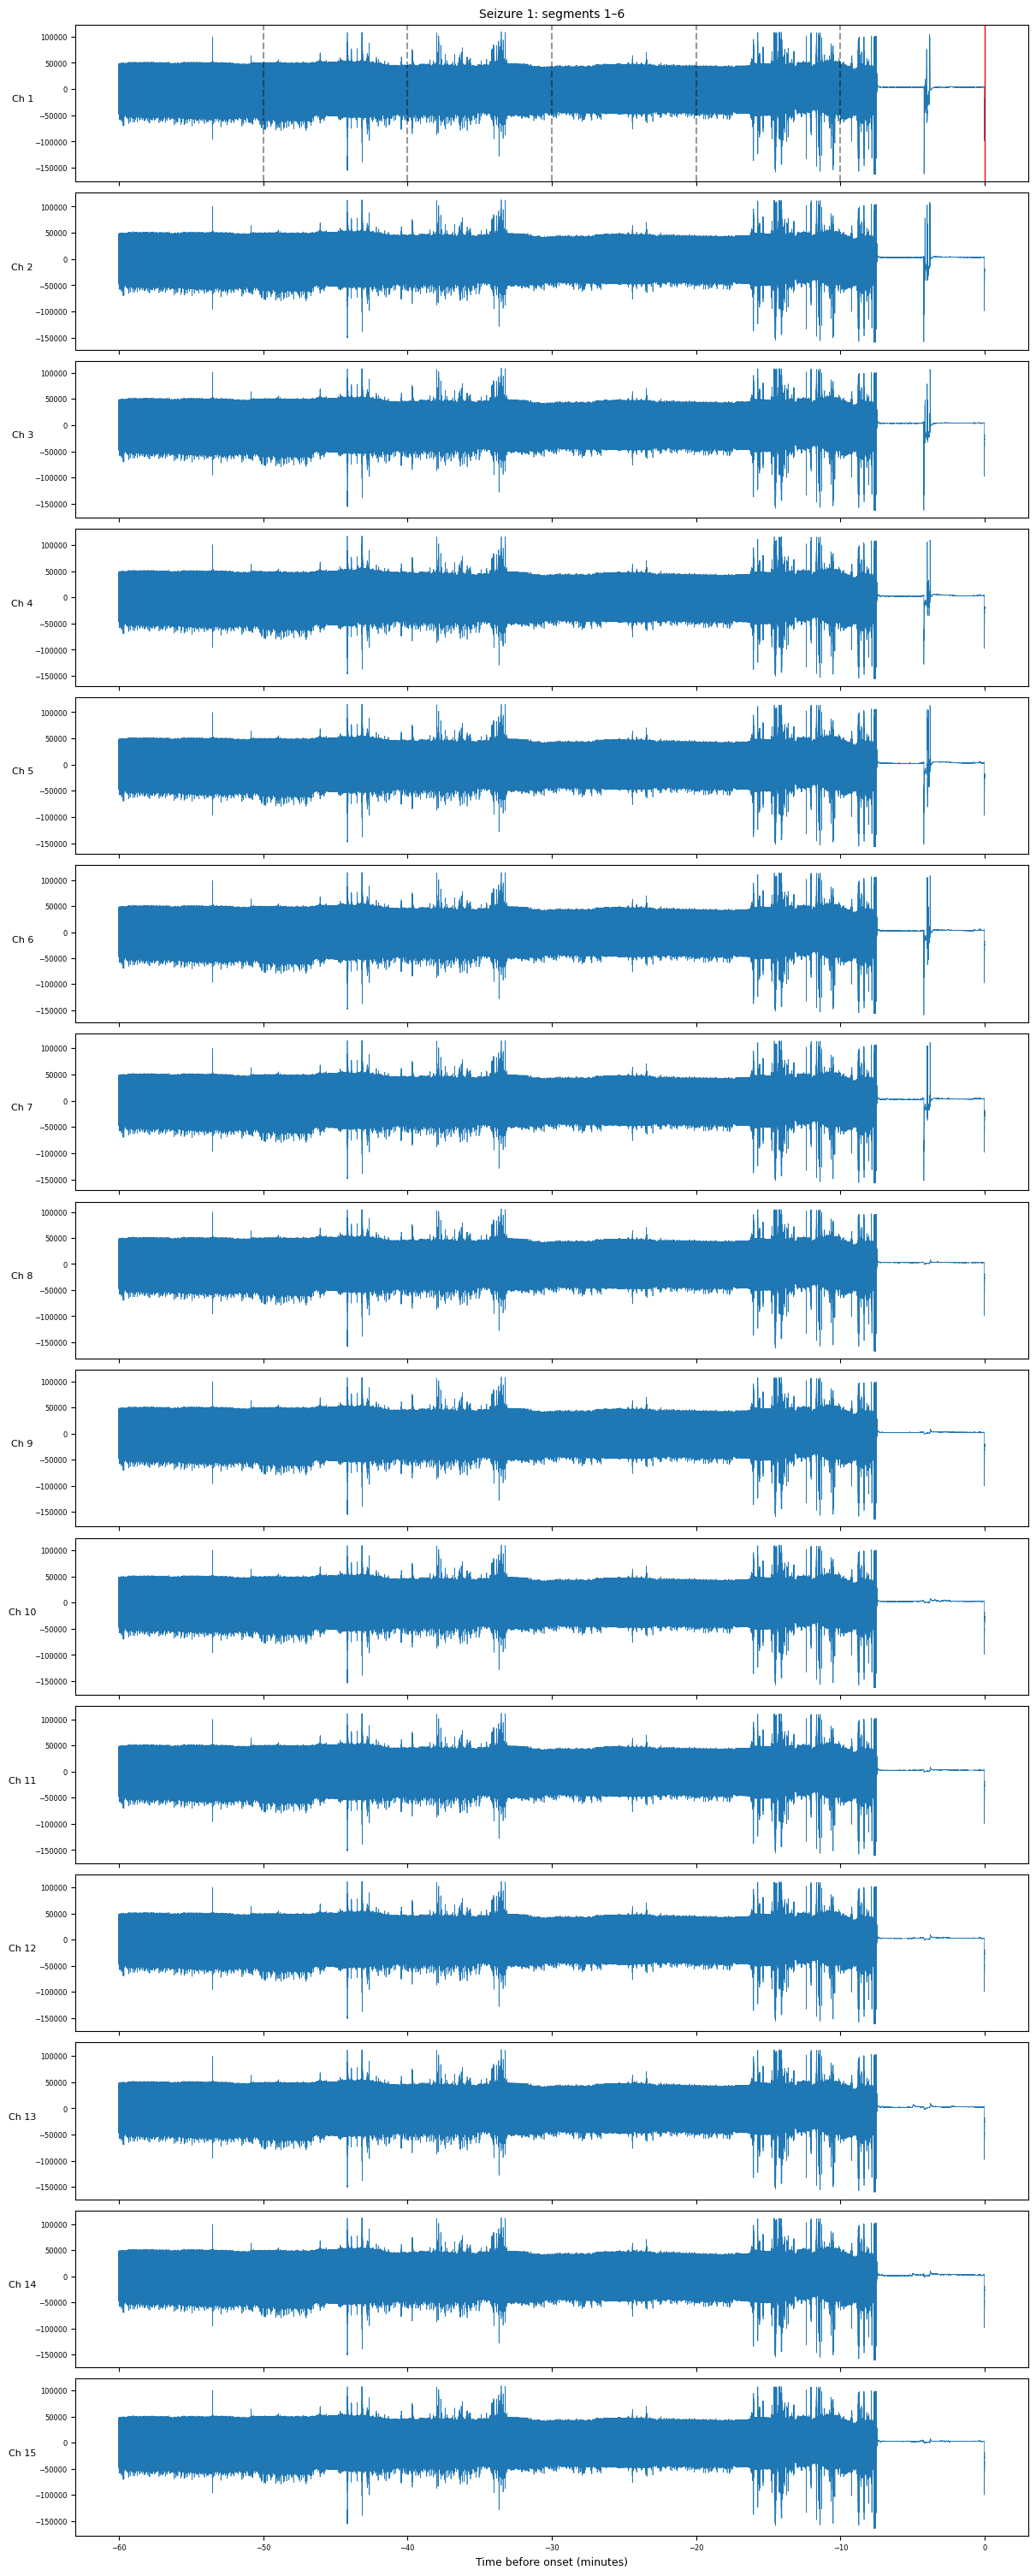

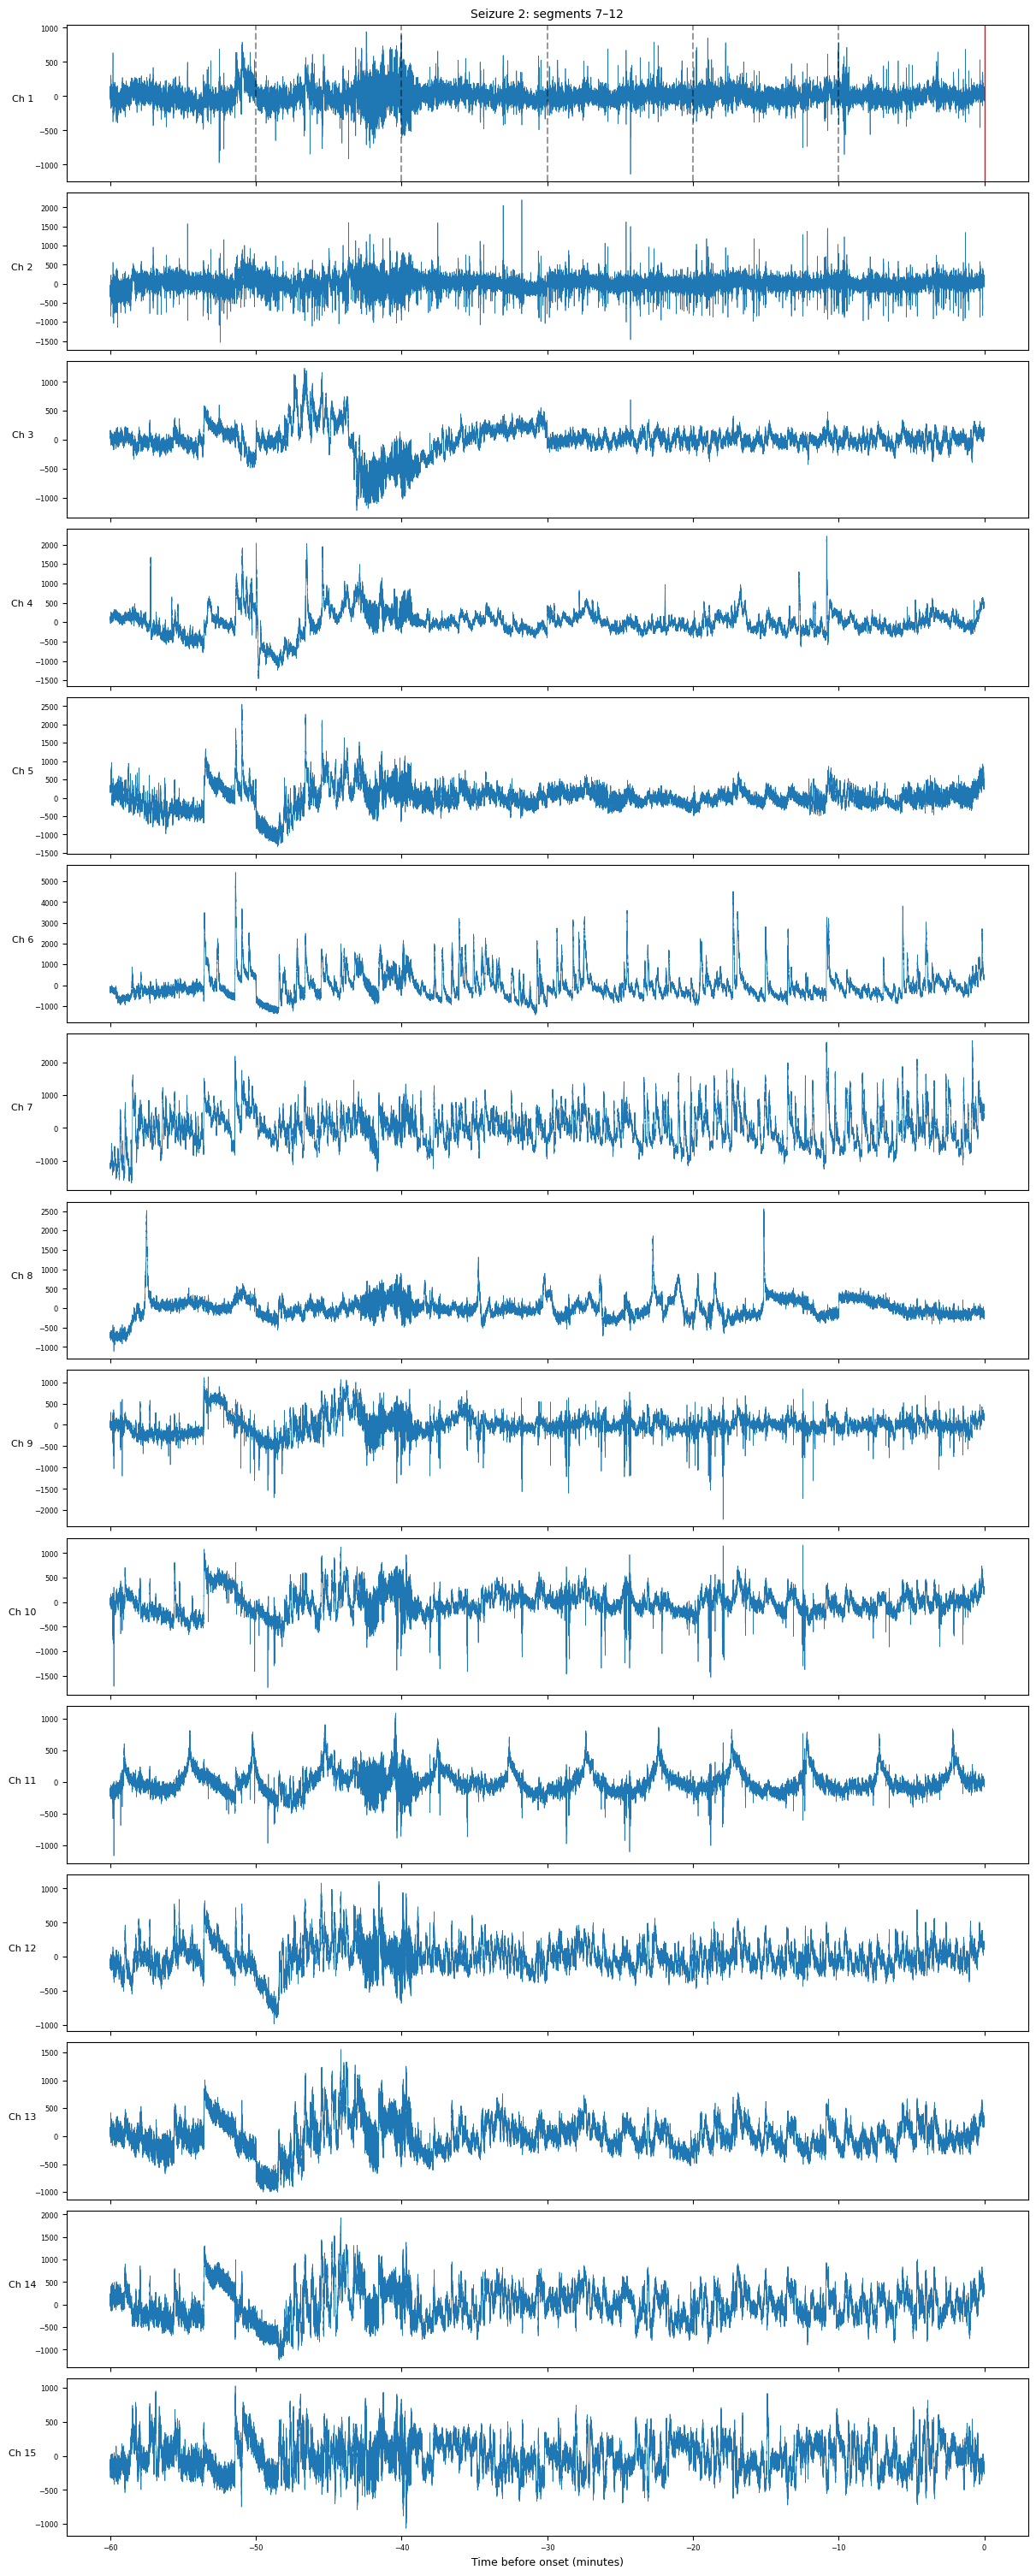

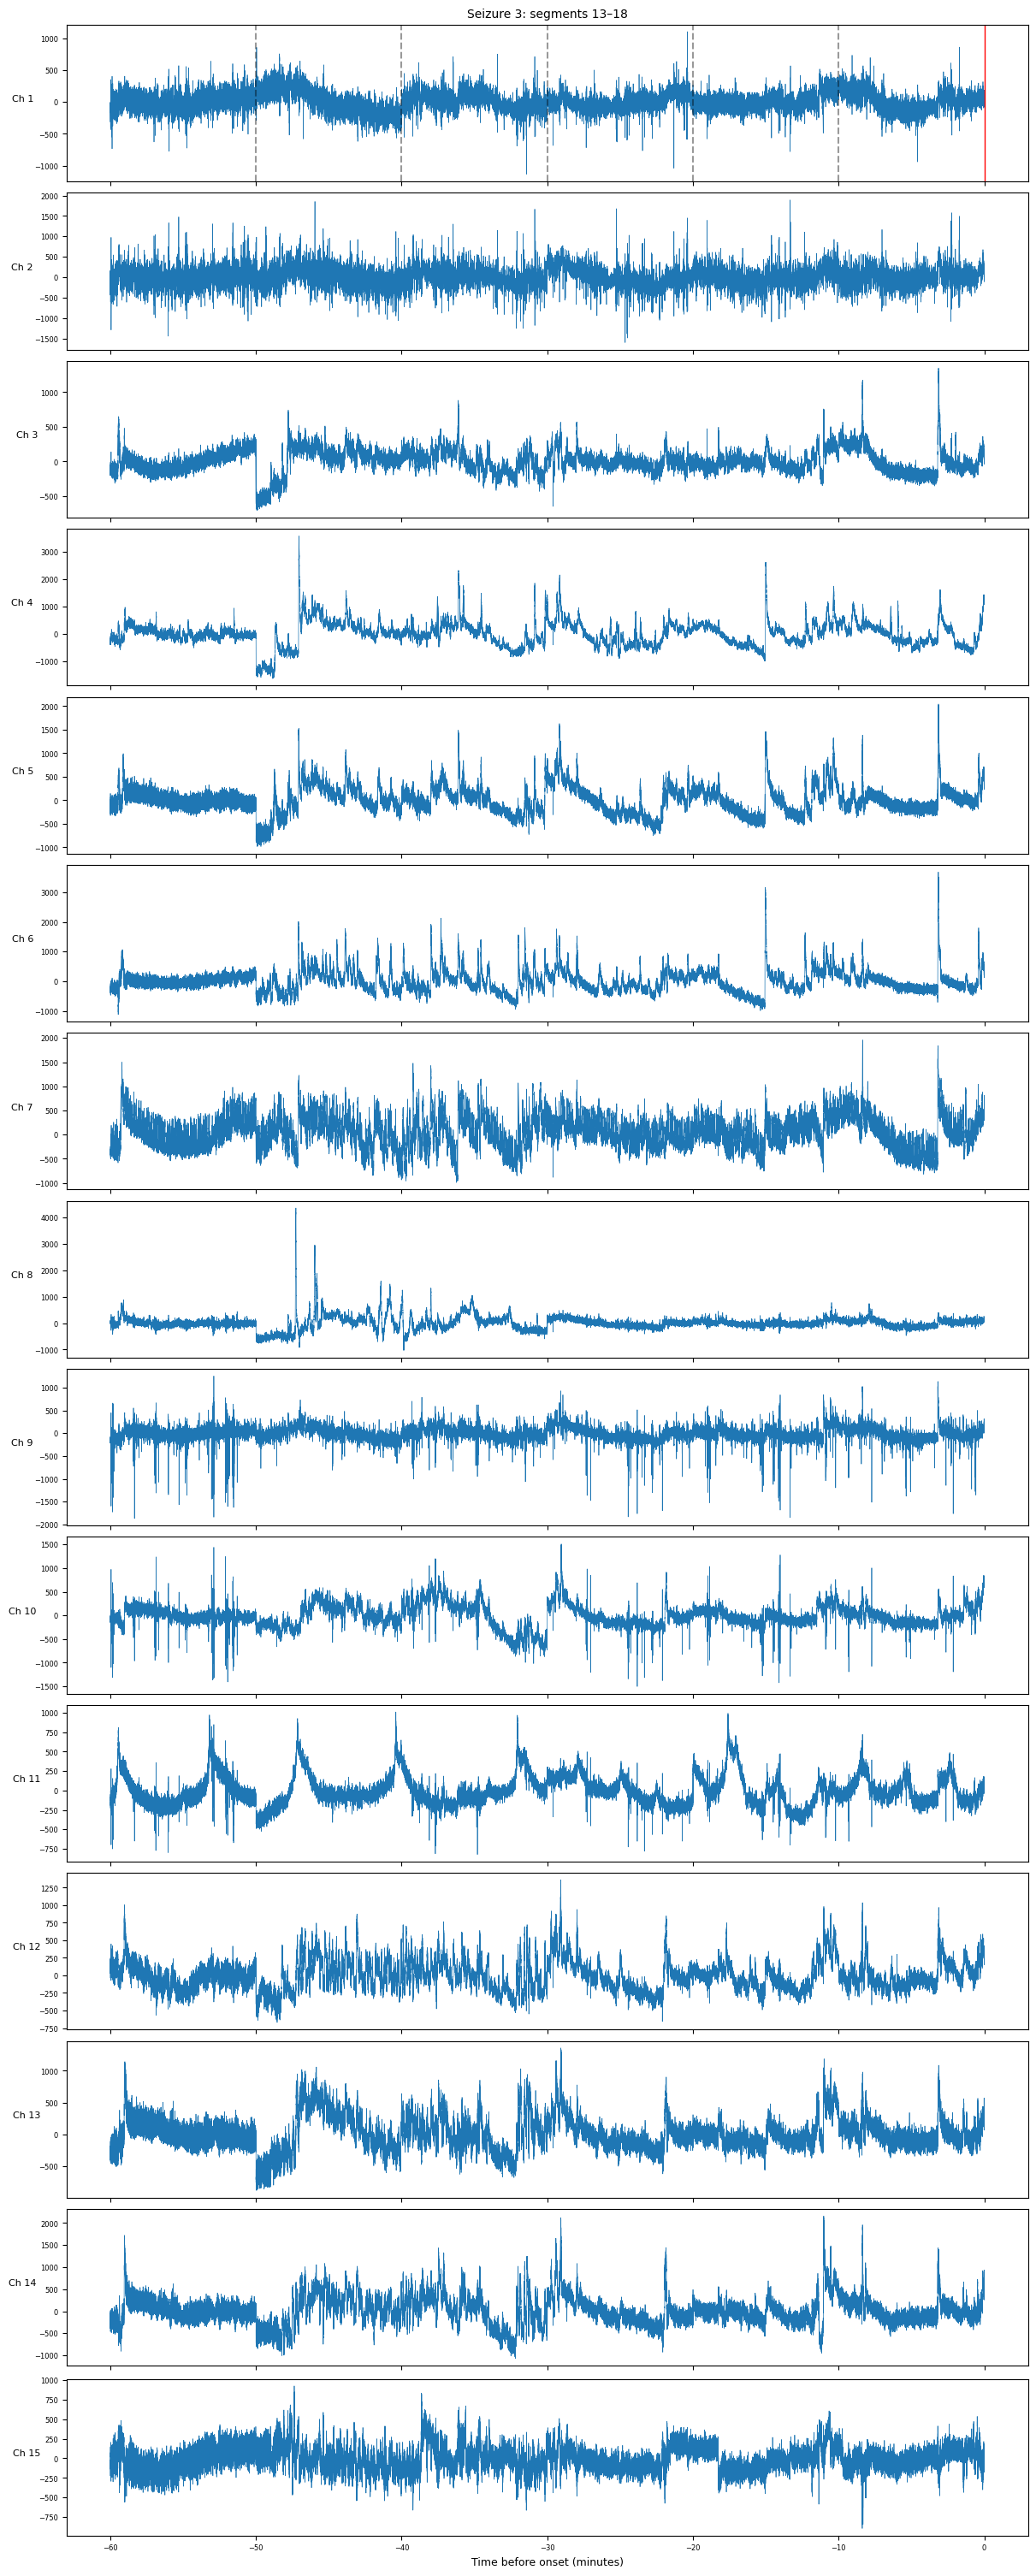

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.signal import decimate

# ─── CONFIG ──────────────────────────────────────────────────────────────────
target_fs   = 500     # Hz down‑sample rate
WS_min      = 10      # each segment is 10 min long
n_channels  = 15      # number of electrodes

# helper to load & downsample one .mat
def load_ds_segment(fn):
    m = loadmat(fn, struct_as_record=False, squeeze_me=True)
    key = next(k for k in m if not k.startswith("__"))
    s   = m[key]
    eeg = s.data                   # shape (15, orig_samps)
    fs  = float(s.sampling_frequency)
    factor = int(round(fs/target_fs))
    return decimate(eeg, factor, axis=1, zero_phase=True)

# the three seizure‐groups: segments 1–6, 7–12, 13–18
groups = [
    list(range(1,  7)),   # seq 1→6 = seizure 1
    list(range(7, 13)),   # seq 7→12 = seizure 2
    list(range(13,19)),   # seq 13→18 = seizure 3
]

for gi, seg_nums in enumerate(groups, start=1):
    # 1) load & ds each of the 6 segments for this group
    clips = []
    for seg in seg_nums:
        fn = f"Patient_1_preictal_segment_{seg:04d}.mat"
        path = os.path.join(mat_dir, fn)
        clips.append(load_ds_segment(path))
    # 2) concatenate along time
    full = np.concatenate(clips, axis=1)  # shape (15, n_samps_total)
    n_samps = full.shape[1]
    # 3) build time axis in minutes before seizure onset
    total_min = WS_min * len(seg_nums)
    t = np.linspace(-total_min, 0, n_samps)  # from -60…0 min for group 1, etc.

    # 4) plot all channels stacked
    fig, axes = plt.subplots(n_channels, 1, figsize=(12, 2*n_channels),
                             sharex=True, constrained_layout=True)
    for ch in range(n_channels):
        axes[ch].plot(t, full[ch], lw=0.5)
        axes[ch].set_ylabel(f"Ch {ch+1}", rotation=0, labelpad=10, fontsize=8)
        axes[ch].tick_params(labelsize=6)
        if ch == 0:
            axes[ch].set_title(f"Seizure {gi}: segments {seg_nums[0]}–{seg_nums[-1]}", fontsize=10)
    axes[-1].set_xlabel("Time before onset (minutes)", fontsize=9)

    # mark segment boundaries every 10 min
    for k in range(1, len(seg_nums)):
        axes[0].axvline(-total_min + k*WS_min, color='k', linestyle='--', alpha=0.4)
    # mark seizure onset at t=0
    axes[0].axvline(0, color='r', linestyle='-', lw=1)

    plt.show()


## Syntax Index:
I)`load_and_explore_segment(mat_file_example)`

*   To be clear:
    *   `data.shape` is **(channels, samples)**.

        For example, (16, 3000000):

        **16 rows**: 16 channels (electrodes)

        **3,000,000 columns**: 3 million samples (time points)

II)`data_length_sec = segment['data_length_sec'][0, 0][0, 0]`
         

*   Why all these `[0, 0]`?
    *   **MATLAB** often saves even scalars as arrays of arrays
    *   **Python mirrors this**: You often need `[0, 0]` (or more) to "unwrap" and reach the real value.
*   How to check what you need?
    *  Use `print(segment['sampling_frequency'])` to see its shape.
    * If it’s `array([[5000]])`, use `[0, 0]`.
    * If it’s `array([[array([[5000]])]])`, use `[0, 0][0, 0]`.

Loading: Patient_1_interictal_segment_0043.mat
Segment key : interictal_segment_43
[[  55   70   80 ...  334  318  295]
 [ -20   -5    6 ...  979  965  944]
 [ 145  161  173 ...  548  532  509]
 ...
 [-166 -151 -141 ...  999  983  961]
 [-813 -799 -791 ... 2031 2015 1993]
 [-442 -426 -416 ... 1744 1728 1705]]

Data shape: (15, 3000000)
Duration: 600 seconds
Sampling frequency: 5000 Hz
Number of channels: 15
Samples per channel: 3000000


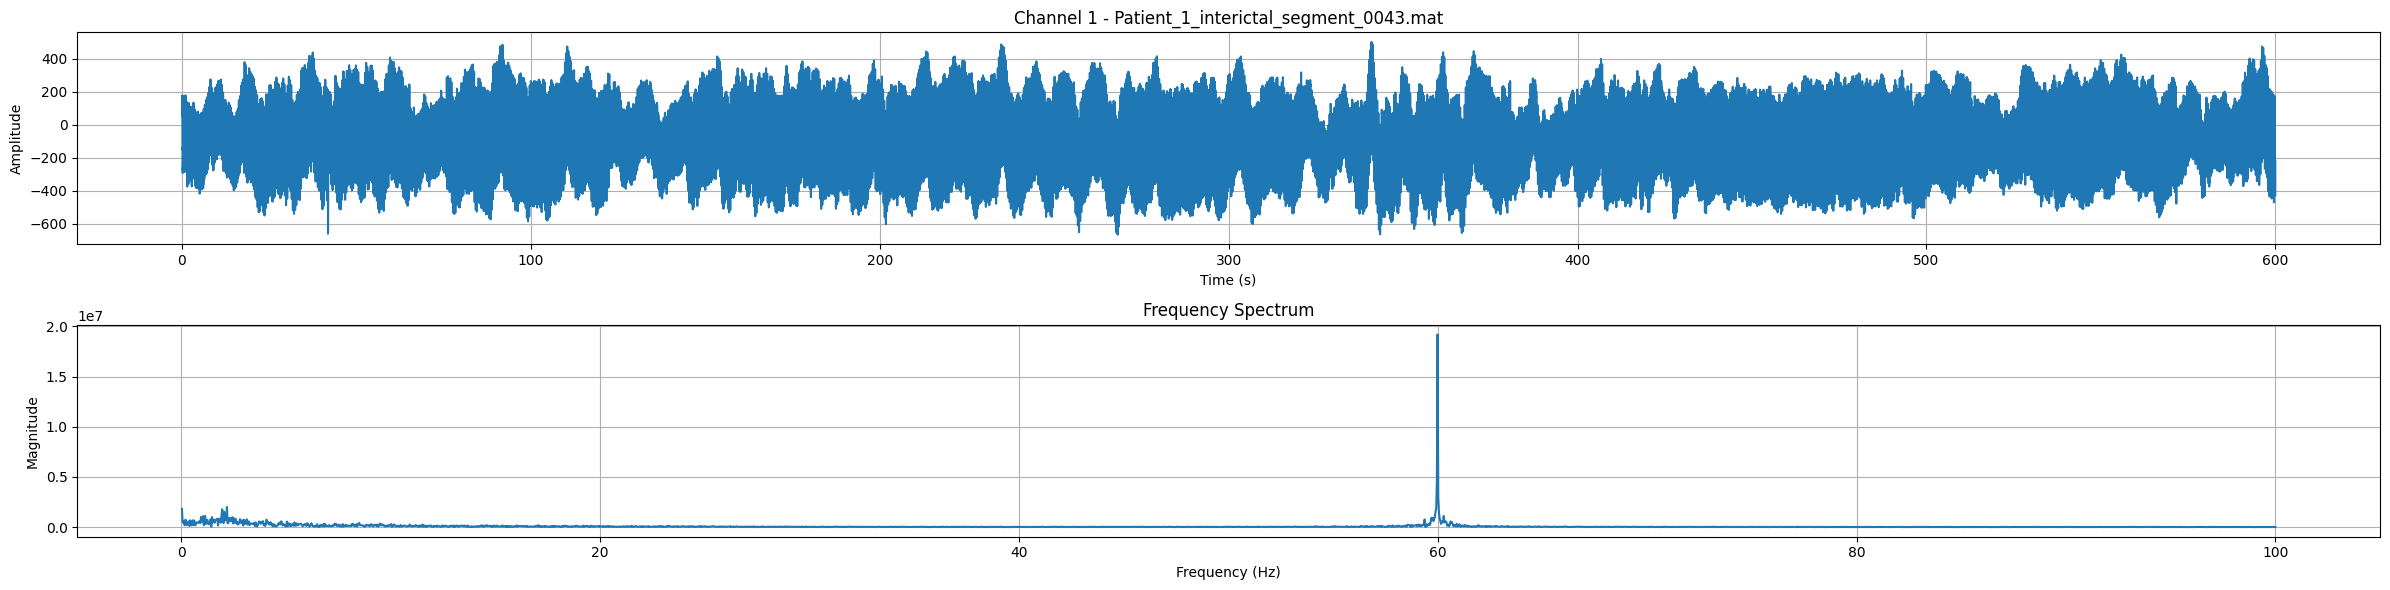

Loading: Patient_1_preictal_segment_0008.mat
Segment key : preictal_segment_8
[[  36   37   37 ...  480  477  473]
 [  77   76   77 ...  186  192  193]
 [ 246  246  245 ... -117 -114 -115]
 ...
 [-631 -633 -634 ...  177  180  180]
 [-418 -421 -423 ...  174  178  177]
 [ 184  183  181 ...  711  713  713]]

Data shape: (15, 3000000)
Duration: 600 seconds
Sampling frequency: 5000 Hz
Number of channels: 15
Samples per channel: 3000000


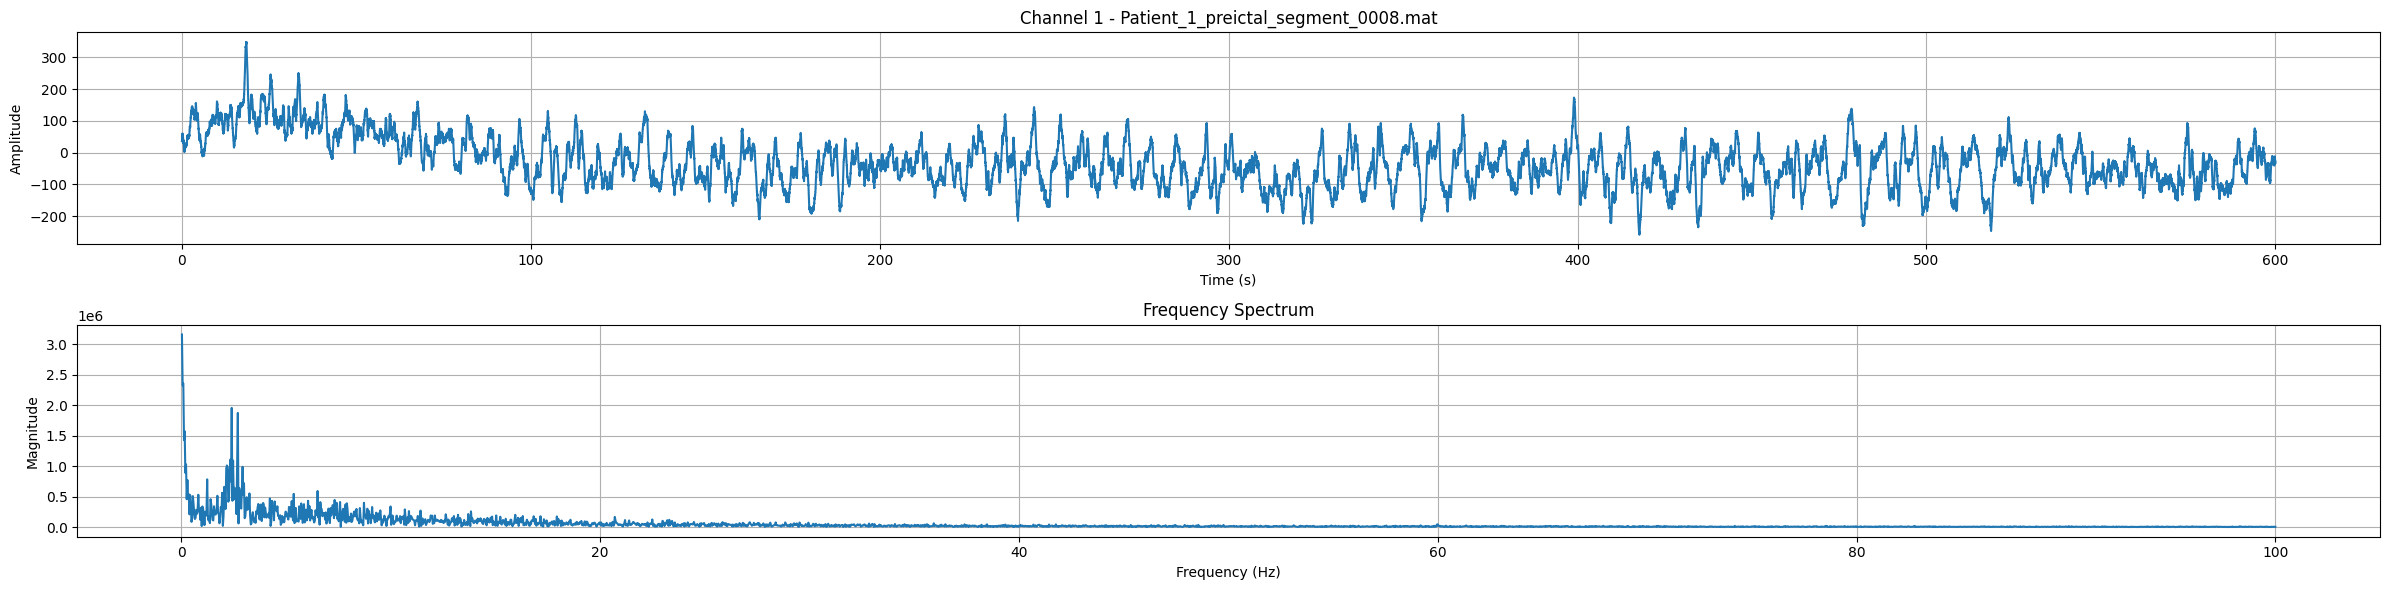

Loading: Patient_1_preictal_segment_0018.mat
Segment key : preictal_segment_18
[[ 185  188  191 ...  182  182  182]
 [-102 -100  -95 ...  181  179  177]
 [ 280  281  285 ...   74   73   72]
 ...
 [  96   98  101 ...  352  351  349]
 [ 216  217  219 ...  364  363  361]
 [ 103  104  105 ...   13   14   14]]

Data shape: (15, 3000000)
Duration: 600 seconds
Sampling frequency: 5000 Hz
Number of channels: 15
Samples per channel: 3000000


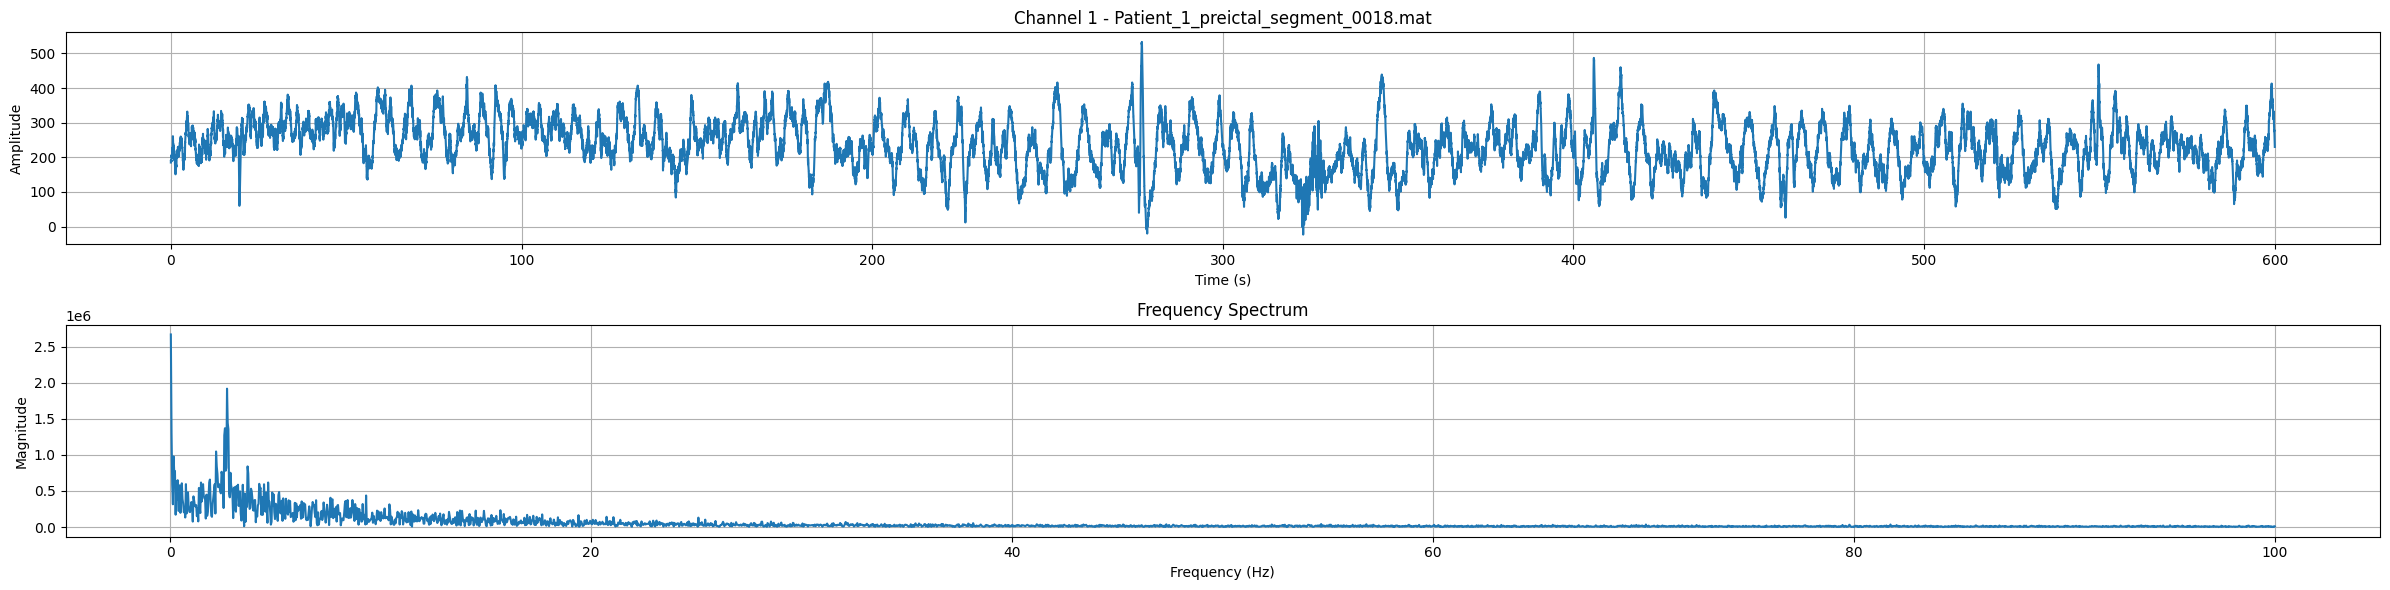

(array([[ 185,  188,  191, ...,  182,  182,  182],
        [-102, -100,  -95, ...,  181,  179,  177],
        [ 280,  281,  285, ...,   74,   73,   72],
        ...,
        [  96,   98,  101, ...,  352,  351,  349],
        [ 216,  217,  219, ...,  364,  363,  361],
        [ 103,  104,  105, ...,   13,   14,   14]], dtype=int16),
 5000)

In [ ]:
def load_and_explore_segment(filepath: str):
  mat_data = sio.loadmat(filepath)
  segment_key = None
  for key in mat_data.keys():
    if 'segment' in key and not key.startswith('_'):
      segment_key = key
      break
  print(f"Loading: {os.path.basename(filepath)}")
  #segment_key = 'interictal_segment_N'
  #That is the key that hold the (1,1) outer array
  print(f"Segment key : {segment_key}")

  segment = mat_data[segment_key]

  # Extract data
  data = segment['data'][0, 0]
  print(data)
  sampling_freq = int(segment['sampling_frequency'][0, 0][0, 0])
  #II ---> in Index
  data_length_sec = segment['data_length_sec'][0, 0][0, 0]

  print(f"\nData shape: {data.shape}")
  print(f"Duration: {data_length_sec} seconds")
  print(f"Sampling frequency: {sampling_freq} Hz")
  print(f"Number of channels: {data.shape[0]}")
  print(f"Samples per channel: {data.shape[1]}")

  # Plot sample data
  plt.figure(figsize=(24, 6))
  #fig, axes = plt.subplots(n_ch, 2, figsize=(12, 2*n_ch), sharex=True)

  # Plot first 5 seconds of first channel
  time_to_plot = 600  # seconds
  samples_to_plot = time_to_plot * 256
  t = np.arange(samples_to_plot) / 256

  plt.subplot(2, 1, 1)
  plt.plot(t, data[0, :samples_to_plot])
  plt.title(f'Channel 1 - {os.path.basename(filepath)}')
  plt.xlabel('Time (s)')
  plt.ylabel('Amplitude')
  plt.grid(True)

  # Plot frequency spectrum
  plt.subplot(2, 1, 2)
  #Feed into a FFT numpy
  freqs = np.fft.fftfreq(samples_to_plot, 1/sampling_freq)
  #Get absolute values getting magnitude of each frequency
  fft_vals = np.abs(np.fft.fft(data[0, :samples_to_plot]))

  # Only plot positive frequencies up to 100 Hz
  pos_mask = (freqs > 0) & (freqs < 100)
  plt.plot(freqs[pos_mask], fft_vals[pos_mask])
  plt.title('Frequency Spectrum')
  plt.xlabel('Frequency (Hz)')
  plt.ylabel('Magnitude')
  plt.grid(True)

  plt.tight_layout()
  plt.show()

  return data, sampling_freq
mat_file_example1 = os.path.join(mat_dir,'Patient_1_interictal_segment_0043.mat')
#I -----> index
load_and_explore_segment(mat_file_example1)
#Second to start of Second Preictal timspan
mat_file_example2 = os.path.join(mat_dir,'Patient_1_preictal_segment_0008.mat')
load_and_explore_segment(mat_file_example2)
#End of Third Preictal timepsan
mat_file_example3 = os.path.join(mat_dir,"Patient_1_preictal_segment_0018.mat")
load_and_explore_segment(mat_file_example3)

1)`segment_data, params, fs, segment_idx, extractor = segment_tuple`
   * segment_tuple
     * Check Structure SYNTAX

2) **Imagine your sampling frequency (fs) is 10 Hz** (10 samples per second) and you have data for 1 second. The ch_segment array would have 10 numbers. For Example,

`ch_segment = [5.2, 8.1, 10.5, 7.0, 2.3, -1.4, -4.8, -3.1, 0.5, 4.9]`

**This is how you interpret it:**

    Index 0 (value 5.2) is the amplitude at Time = 0.0s

    Index 1 (value 8.1) is the amplitude at Time = 0.1s

    Index 2 (value 10.5) is the amplitude at Time = 0.2s

    ...and so on, until the last sample at Time = 0.9s.

Final Exmaple:

 I) **Input (segment_data)**:
```
          Time 1   Time 2   Time 3   ...
         -------------------------------
Channel 1 |  10µV  |  12µV  |  11µV  | ...
Channel 2 |   5µV  |   6µV  |   8µV  | ...
Channel 3 |  20µV  |  22µV  |  21µV  | ...
...       |  ...   |  ...   |  ...   | ...

```

II) Calculate Features for Each Channel

The code then loops through this table one row (one channel) at a time. For each channel, it performs the DWT and DESA calculations to get a 1D array of features.

**Intermediate Result (a list of feature arrays):**

```
'''
          Feature A | Feature B | Feature C | ...
         -----------------------------------------
Channel 1 |   1.5   |   0.8   |   2.3   | ...
Channel 2 |   1.7   |   0.9   |   2.1   | ...
Channel 3 |   1.3   |   0.7   |   2.5   | ...
...       |   ...   |   ...   |   ...   | ...

```
III)avg_features
```
# A list where each item is the feature array from one channel
channel_features = [
    [1.5, 0.8, 2.3],  # Features from Channel 1
    [1.7, 0.9, 2.1],  # Features from Channel 2
    [1.3, 0.7, 2.5]   # Features from Channel 3
]
```



The Averaging Operation (np.mean(..., axis=0))

The function then averages down the columns:
    First column average: (1.5 + 1.7 + 1.3) / 3 = 1.5
    Second column average: (0.8 + 0.9 + 0.7) / 3 = 0.8
    Third column average: (2.3 + 2.1 + 2.5) / 3 = 2.3

**After Averaging (The Final 1D Array)**

The final output is a **single 1D NumPy array** containing those averages:
Python

`avg_features = [1.5, 0.8, 2.3]`

In [ ]:
#A tuple is an ordered, immutable collection of items (e.g., (item1, item2, item3)).
def extract_features_for_segment(segment_tuple: Tuple) -> np.ndarray:
    """
    Extracts features for a single segment of EEG data.
    This function is designed to be called by a multiprocessing pool.
    """
    # Index --> I
    segment_data, params, fs, segment_idx, extractor = segment_tuple

    # number of channels
    n_channels = segment_data.shape[0]
    channel_features = []

    for ch in range(n_channels):
        # Index --> II
        #NumPy array slicing resulting in a 1D array
        ch_segment = segment_data[ch, :]
        #ProperSeizurePredictor instance extractor calls extract_segemnt_features method to perform WVT and
        features = extractor.extract_segment_features(
            ch_segment, params['mother_wavelet'], params['NL']
        )
        # Final Exmaple --> II
        channel_features.append(features)

    # Average features across all channels (spatial averaging)
    avg_features = np.mean(channel_features, axis=0)
    return avg_features

def create_feature_vectors(self: 'ProperSeizurePredictor', data: np.ndarray, params: Dict, fs: int) -> np.ndarray:
    """
    Creates feature vectors sequentially. This function is run inside a main
    worker process and should not have its own parallelism or progress bar.
    """
    # Windows Size wrt to fs time indexing
    window_samples = params['Ws'] * fs
    # Ne is the number of small segments that will be concatenated into one final feature vector.
    n_samples = data.shape[1]

    Ne = params['Ne']

    tasks_to_process = []
    # range(start, stop, step)
    '''
      SYNTAX
      1) step :window_samples * Ne (jump forward by the length of one full feature vector in each iteration).
      2) stop :n_samples - window_samples * Ne + 1 (stop before the signal ends, ensuring there's enough data for a full final feature vector).

    '''
    for start_idx in range(0, n_samples - window_samples * Ne + 1, window_samples * Ne):
        for seg_offset in range(Ne):
            #SYNTAX
            seg_start = start_idx + seg_offset * window_samples
            seg_end = seg_start + window_samples
            #Take all channels , seg_start:seg_end specifies the time window for the segment.
            segment_data = data[:, seg_start:seg_end]
            #task_to_progress list
            tasks_to_process.append((segment_data, params, fs, seg_start, self))
            #Final Example -->

    if not tasks_to_process:
        return np.array([])

    # Run tasks sequentially as a simple list comprehension.
    all_extracted_features = [extract_features_for_segment(task) for task in tasks_to_process]

    # Reconstruct the final feature vectors.
    all_feature_vectors = []
    num_final_vectors = len(all_extracted_features) // Ne
    for i in range(num_final_vectors):
        start_slice = i * Ne
        end_slice = start_slice + Ne
        feature_vector = np.concatenate(all_extracted_features[start_slice:end_slice])
        all_feature_vectors.append(feature_vector)

    return np.array(all_feature_vectors)


def debug_print(msg, level=1):
    """Print debug messages based on level"""
    if DEBUG_MODE and level <= 2:
        print(f"[DEBUG] {msg}")


## Syntax Index:
I)`random.seed(N)`

*   **To be clear**:
    *   ```
    import random
        random.seed(99)
        print([random.randint(0, 10) for _ in range(4)])  
          ```
        ### Always: [2, 7, 7, 6]
        *seed helps reproduce the same sequence of random numbers*

II)`self.seizure_data`

*   It’s a member variable of the **ImprovedPatientSpecificSeizurePredictorCV object** that contains an *instance* of the **ImprovedSeizureData class**.
* What does `self` do here?   
    *   `self` refers to this instance of the class.
    *   When you write `self.seizure_data`, you’re saying “store this object as a property on myself (this pipeline object), so I can use it in all my methods.”
    * so `self.var = A()` in B class ---> `self.var.functionofA()` ***to access function of A in B***
* Some self() examples /tips
    ```
    def __init__(self):
        self.var = A()
    def foo(self):
        self.var.some_a_function()      # CORRECT
        var.some_a_function()           # NameError: 'var' is not defined unless declared locally
    ```
    
* You Defined var as a Local Variable (not with self.)
  * If you write var = A() inside a method (not self.var = A()), then you can use var.some_a_function() inside that method only.
  * But this variable does not persist between methods—it’s just a temporary variable.
```
class B:
    def foo(self):
        var = A()
        var.some_a_function()   # works inside foo()
    
    def bar(self):
        var.some_a_function()   # NameError: var not defined in this scope
```
  * Can self. variables be used by other classes?
     * Only if you pass the object around.
     *  If you do **obj = MyClass()** and pass obj to another class, you can access its *self. variables* as **obj.x, obj.y, etc**.
     * 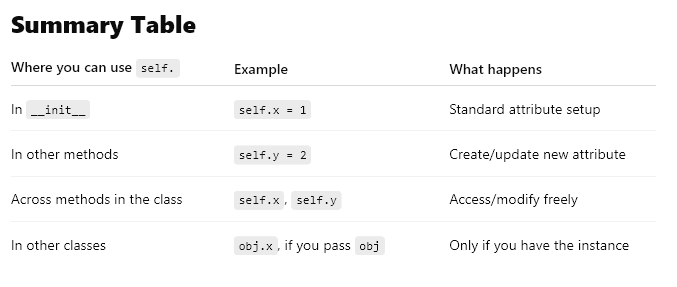
* Why 6?
   * In many public epilepsy datasets (**like the American Epilepsy Kaggle dataset**), each seizure event is split into multiple smaller preictal files—often of fixed length (e.g., **10 minutes each**).

  * In this dataset, for each seizure there are typically 6 preictal segments, which together cover the preictal period (e.g., the hour before a seizure: 6 × 10min = 60min).


In [ ]:
class SeizureData:
  #Feature extraction pipeline for EEG seizure prediction.
  def __init__(self, patient_id: str, data_dir: str, random_seed: int = 42):
        self.patient_id = patient_id
        self.data_dir = data_dir
        self.random_seed = random_seed

        # Set seeds
        random.seed(random_seed)
        np.random.seed(random_seed)

        print(f"Initializing seizure data for {patient_id}...")
        self.seizure_records = self._organize_seizure_records()
        self._validate_data()
  # in python _function the underscore indicates
  def _load_mat_file(self, filepath: str, target_fs: int = 256) -> Tuple[np.ndarray, int]:
        """Load and preprocess a single .mat file"""
        try:
            mat_data = sio.loadmat(filepath)

            segment_key = None
            for key in mat_data.keys():
                if 'segment' in key and not key.startswith('_'):
                    segment_key = key
                    break

            if segment_key is None:
                return None, None

            segment = mat_data[segment_key]
            data = segment['data'][0, 0].astype(np.float32)
            original_fs = int(segment['sampling_frequency'][0, 0][0, 0])

            if original_fs > target_fs:
                num_samples = int(data.shape[1] * (target_fs / original_fs))
                data = resample(data, num_samples, axis=1)
                fs = target_fs
            else:
                fs = original_fs

            data = data - np.mean(data, axis=1, keepdims=True)
            channel_stds = np.std(data, axis=1, keepdims=True)
            channel_stds[channel_stds < 1e-6] = 1.0
            data = data / channel_stds

            return data, fs

        except Exception as e:
            print(f"Error loading {filepath}: {e}")
            return None, None
  "Predicate data last two segments concatinated in seizure data"
  def _organize_seizure_records(self) -> List[Dict]:
        """Organize files into seizure records"""
        interictal_files = sorted(glob.glob(os.path.join(self.data_dir, f"{self.patient_id}_interictal_*.mat")))
        preictal_files = sorted(glob.glob(os.path.join(self.data_dir, f"{self.patient_id}_preictal_*.mat")))

        print(f"Found {len(interictal_files)} interictal files")
        print(f"Found {len(preictal_files)} preictal files")

        # Load all files with progress bar
        print("Loading EEG files...")
        all_data = {}

        for f in tqdm(interictal_files + preictal_files, desc="Loading files"):
            data, fs = self._load_mat_file(f)
            if data is not None:
                all_data[f] = (data, fs)

        # Organize into seizures
        files_per_seizure = 6
        n_seizures = max(1, len(preictal_files) // files_per_seizure)

        seizure_records = []

        for i in range(n_seizures):

            # 0 * 6 = 0 , 1 * 6 = 6 , 2 * 6 = 12
            start_idx = i * files_per_seizure
            end_idx = min((i + 1) * files_per_seizure, len(preictal_files))

            # Get last 2 preictal files for this seizure 20 mins
            seizure_files = preictal_files[start_idx:end_idx]
            if len(seizure_files) >= 2:
                seizure_files = seizure_files[-2:]

            # Load and concatenate preictal
            preictal_arrays = []
            fs = None
            for f in seizure_files:
                if f in all_data:
                    data, file_fs = all_data[f]
                    preictal_arrays.append(data)
                    fs = file_fs

            if preictal_arrays:
                # 2D numpy array rows number of ch , columns , timepoint samples
                preictal_data = np.concatenate(preictal_arrays, axis=1)

                # Random interictal selection
                n_inter = min(random.randint(2, 4), len(interictal_files))
                selected_inter = random.sample(interictal_files, n_inter)

                interictal_list = []
                for f in selected_inter:
                    if f in all_data:
                        data, _ = all_data[f]
                        interictal_list.append(data)

                if interictal_list:
                    seizure_records.append({
                        'seizure_id': i,
                        'preictal_data': preictal_data,
                        'preictal_fs': fs,
                        'interictal_data': interictal_list,
                        'interictal_fs': fs
                    })

        return seizure_records
  #ChatGPT validate
  def _validate_data(self):
        """Validate loaded data quality"""
        print(f"\nValidating {len(self.seizure_records)} seizure records...")

        for i, record in enumerate(self.seizure_records):
            pre_shape = record['preictal_data'].shape
            pre_duration = pre_shape[1] / record['preictal_fs']

            print(f"Seizure {i}: {pre_duration:.1f}s preictal, {len(record['interictal_data'])} interictal files")

            if np.any(np.isnan(record['preictal_data'])):
                print(f"  WARNING: NaN values in preictal data!")

            channel_vars = np.var(record['preictal_data'], axis=1)
            if np.any(channel_vars < 1e-6):
                print(f"  WARNING: Low variance channels detected!")


I)Why *`*.extend()*`* is Used

The goal is to create a single, flat list of features.

   *  `list.append([item1, item2])` would add the list itself as one element, creating a nested list like `[[1.5, 0.8], [1.7, 0.9]]`.

   *  `list.extend([item1, item2])` adds the individual elements from the given list, creating the desired flat list like `[1.5, 0.8, 1.7, 0.9]`.

In [ ]:
class ProperSeizurePredictor:
    """Seizure predictor with proper DESA and wavelet implementations"""

    def __init__(self, patient_id: str, data_dir: str, n_jobs: int = -1, random_seed: int = 42):
        self.patient_id = patient_id
        self.data_dir = data_dir
        self.n_jobs = n_jobs if n_jobs > 0 else cpu_count()
        self.random_seed = random_seed

        print(f"Initializing predictor with {self.n_jobs} cores")

        self.seizure_data = SeizureData(patient_id, data_dir, random_seed)

        self.param_grid = {
            'NL': [5, 7, 9],
            'L': [10, 20],
            'Ws': [5, 10, 15, 20],
            'mother_wavelet': ['db6', 'coif1', 'sym3', 'bior2.6'],
            'Ne': [6],
            'classifier': ['SVM', 'RF', 'Logistic', 'Gaussian']
        }

        self.best_params = None
        self.results_history = []
        # --- REMOVED Manager and shared progress bar to fix the error and simplify ---
    #Chat Help
    '''
     mathematical engine for the DESA algorithm
     unlike other methods that average over a window, the TKEO provides an instantaneous measure, making
     it excellent at detecting rapid changes in both a wave's strength (amplitude) and its oscillation speed (frequency).
    '''
    def _teager_kaiser_operator(self, x: np.ndarray) -> np.ndarray:
        if len(x) < 3: return np.array([])
        #single 1D NumPy array
        return x[1:-1]**2 - x[:-2] * x[2:]
    #Chat Help
    def _desa_algorithm(self, x: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        if len(x) < 4: return np.array([]), np.array([])

        y = np.diff(x)
        psi_x = self._teager_kaiser_operator(x)
        psi_y = self._teager_kaiser_operator(y)

        if len(psi_x) == 0 or len(psi_y) == 0: return np.array([]), np.array([])

        n_points = min(len(psi_x), len(psi_y) - 1)
        if n_points <= 0: return np.array([]), np.array([])

        psi_x_sliced, psi_y_sliced, psi_y_next_sliced = psi_x[:n_points], psi_y[:n_points], psi_y[1:n_points + 1]
        omega, amplitude = np.zeros(n_points), np.zeros(n_points)
        denom = 4 * psi_x_sliced
        safe_denom_mask = np.abs(denom) > 1e-10
        arg = np.ones(n_points)
        arg[safe_denom_mask] = 1 - (psi_y_sliced[safe_denom_mask] + psi_y_next_sliced[safe_denom_mask]) / denom[safe_denom_mask]
        omega = np.arccos(np.clip(arg, -1, 1))
        sin_omega = np.sin(omega)
        safe_sin_mask = np.abs(sin_omega) > 1e-10
        safe_mask = safe_denom_mask & safe_sin_mask
        amplitude[safe_mask] = np.sqrt(np.abs(psi_x_sliced[safe_mask] / (sin_omega[safe_mask]**2)))
        #smooths need to plot msall window slide
        #The raw amplitude and omega arrays calculated by DESA can have sharp, single-point spikes that are just noise
        if len(omega) > 5:
            omega = medfilt(omega, kernel_size=5)
            amplitude = medfilt(amplitude, kernel_size=5)

        return amplitude, omega
    #wavelet param
    def extract_segment_features(self, segment: np.ndarray, wavelet: str, levels: int) -> np.ndarray:
        features = []
        #This is a safety check. np.std() calculates the standard deviation. If the standard deviation is zero (meaning the signal is a flat line), dividing by it would cause an error.
        if np.std(segment) > 0:
            #Z-score standardization
            segment = (segment - np.mean(segment)) / np.std(segment)

        try:
           #It returns a list of coefficient arrays (coeffs).
            coeffs = pywt.wavedec(segment, wavelet, level=levels)
            #Jumps to D level coeffs
            for i in range(1, levels + 1):
                if i <= len(coeffs) - 1:
                    detail = coeffs[len(coeffs) - i]
                    #amplitude and freqeuncy of one level
                    amplitude, frequency = self._desa_algorithm(detail)
                    features.extend([np.mean(amplitude) if len(amplitude) > 0 else 0, np.mean(frequency) if len(frequency) > 0 else 0])
                else: features.extend([0, 0])
            #Goes back to Aproximation
            if len(coeffs) > 0:
                approx = coeffs[0]
                # tuple unpacking
                amplitude, frequency = self._desa_algorithm(approx)
                # Index --> I
                features.extend([np.mean(amplitude) if len(amplitude) > 0 else 0, np.mean(frequency) if len(frequency) > 0 else 0])
            else: features.extend([0, 0])
        except Exception as e:
            debug_print(f"Feature extraction error: {e}", level=2)
            features = [0] * (2 * (levels + 1))
        return np.array(features)

    def extract_features_for_seizure(self, seizure_record: Dict, params: Dict) -> Tuple[np.ndarray, np.ndarray]:
        all_features, all_labels = [], []
        L_samples = params['L'] * 60 * seizure_record['preictal_fs']

        preictal_data = seizure_record['preictal_data']
        if preictal_data.shape[1] > L_samples:
            preictal_data = preictal_data[:, -L_samples:]

        features = create_feature_vectors(self, preictal_data, params, seizure_record['preictal_fs'])
        if len(features) > 0:
            all_features.append(features)
            all_labels.extend([1] * len(features))

        for i, inter_data in enumerate(seizure_record['interictal_data']):
            if inter_data.shape[1] > L_samples:
                inter_data = inter_data[:, -L_samples:]

            features = create_feature_vectors(self, inter_data, params, seizure_record['interictal_fs'])
            if len(features) > 0:
                all_features.append(features)
                all_labels.extend([0] * len(features))

        return (np.vstack(all_features), np.array(all_labels)) if all_features else (np.array([]), np.array([]))

    def evaluate_single_fold(self, train_seizures: List[Dict], test_seizure: Dict, params: Dict, verbose: bool = False) -> Optional[Dict]:
        X_train_list, y_train_list = [], []
        for seizure in train_seizures:
            X, y = self.extract_features_for_seizure(seizure, params)
            if len(X) > 0:
                X_train_list.append(X)
                y_train_list.append(y)

        if not X_train_list: return None

        X_train, y_train = np.vstack(X_train_list), np.hstack(y_train_list)
        X_test, y_test = self.extract_features_for_seizure(test_seizure, params)

        if len(X_test) == 0: return None

        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        clf_name = params['classifier']
        if clf_name == 'SVM': clf = SVC(kernel='rbf', probability=True, random_state=self.random_seed)
        elif clf_name == 'RF': clf = RandomForestClassifier(n_estimators=100, random_state=self.random_seed)
        elif clf_name == 'Logistic': clf = LogisticRegression(max_iter=1000, random_state=self.random_seed)
        else: clf = GaussianProcessClassifier(random_state=self.random_seed)

        clf.fit(X_train_scaled, y_train)
        y_pred = clf.predict(X_test_scaled)
        cm = confusion_matrix(y_test, y_pred)

        if cm.shape == (2, 2):
            tn, fp, fn, tp = cm.ravel()
            accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0
            sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
            false_alarm = fp / (fp + tn) if (fp + tn) > 0 else 0
        else:
            accuracy, sensitivity, false_alarm = accuracy_score(y_test, y_pred), 0, 0

        best_k = self._find_best_k(y_test, y_pred, params['L'])

        return {'accuracy': accuracy, 'sensitivity': sensitivity, 'false_alarm_rate': false_alarm, 'K': best_k, 'confusion_matrix': cm.tolist()}

    def _find_best_k(self, y_true: np.ndarray, y_pred: np.ndarray, L: int) -> int:
        if len(y_pred) < L: return int(L * 0.6) if L > 0 else 1
        best_k, best_acc = 1, 0
        for k in range(1, L + 1):
            correct, total = 0, 0
            for i in range(len(y_pred) - L + 1):
                window_true, window_pred = y_true[i:i+L], y_pred[i:i+L]
                if np.sum(window_pred) >= k:
                    if np.any(window_true == 1): correct += 1
                elif np.all(window_true == 0): correct += 1
                total += 1
            if total > 0:
                acc = correct / total
                if acc > best_acc: best_acc, best_k = acc, k
        return best_k

    def evaluate_parameters(self, params_tuple: Tuple, verbose: bool = False) -> Optional[Dict]:
        NL, L, Ws, wavelet, Ne, clf_name = params_tuple
        params = {'NL': NL, 'L': L, 'Ws': Ws, 'mother_wavelet': wavelet, 'Ne': Ne, 'classifier': clf_name}

        seizures = self.seizure_data.seizure_records
        fold_results = [res for s in seizures if (res := self.evaluate_single_fold([seizure for seizure in seizures if seizure['seizure_id'] != s['seizure_id']], s, params, verbose)) is not None]

        if not fold_results: return None

        return {
            'params': params,
            'accuracy': np.mean([r['accuracy'] for r in fold_results]), 'accuracy_std': np.std([r['accuracy'] for r in fold_results]),
            'sensitivity': np.mean([r['sensitivity'] for r in fold_results]), 'sensitivity_std': np.std([r['sensitivity'] for r in fold_results]),
            'false_alarm_rate': np.mean([r['false_alarm_rate'] for r in fold_results]), 'false_alarm_std': np.std([r['false_alarm_rate'] for r in fold_results]),
            'K': int(np.mean([r['K'] for r in fold_results])), 'n_folds': len(fold_results)
        }

    def optimize_parameters(self, n_jobs: int = None):
        """Run full parameter optimization with a single, clean progress bar."""
        if n_jobs is None: n_jobs = self.n_jobs

        param_combinations = list(product(
            self.param_grid['NL'], self.param_grid['L'], self.param_grid['Ws'],
            self.param_grid['mother_wavelet'], self.param_grid['Ne'], self.param_grid['classifier']
        ))

        # --- CORRECTED: Inform the user of the workload, then show one clean progress bar. ---
        n_seizures = len(self.seizure_data.seizure_records)
        total_folds = len(param_combinations) * n_seizures
        print(f"\n💡 Patient has {n_seizures} seizure records for leave-one-out CV.")
        print(f"Total parameter combinations to test: {len(param_combinations)}")
        print(f"Total cross-validation folds to process: {total_folds}")
        print(f"Using {n_jobs} processes.")

        start_time = time.time()

        with ProcessPoolExecutor(max_workers=n_jobs) as executor:
            # This is the single, clean progress bar for the entire job.
            results = list(tqdm(
                executor.map(self.evaluate_parameters, param_combinations),
                total=len(param_combinations),
                desc="🚀 Evaluating Parameters"
            ))

        results = [r for r in results if r is not None]

        elapsed_time = time.time() - start_time
        print(f"\nOptimization completed in {elapsed_time:.1f} seconds")
        print(f"Valid results: {len(results)}/{len(param_combinations)}")

        if not results:
            print("No valid results!")
            return None

        results_df = pd.DataFrame([
            {
                'NL': r['params']['NL'], 'L': r['params']['L'], 'Ws': r['params']['Ws'],
                'wavelet': r['params']['mother_wavelet'], 'classifier': r['params']['classifier'],
                'accuracy': r['accuracy'], 'accuracy_std': r['accuracy_std'],
                'sensitivity': r['sensitivity'], 'false_alarm_rate': r['false_alarm_rate'], 'K': r['K']
            } for r in results
        ])

        if results_df.empty:
            print("No valid results after processing.")
            return None

        best_idx = results_df['accuracy'].idxmax()
        self.best_params = results[best_idx]['params']

        print("\n" + "="*80)
        print("TOP 10 PARAMETER COMBINATIONS:")
        print("="*80)
        print(results_df.nlargest(10, 'accuracy').to_string(index=False))

        print("\n" + "="*80)
        print(f"BEST PARAMETERS for {self.patient_id}:")
        print("="*80)
        for key, value in self.best_params.items():
            print(f"  {key}: {value}")

        best_result = results[best_idx]
        print(f"\nPerformance:")
        print(f"  Accuracy: {best_result['accuracy']:.1%} ± {best_result['accuracy_std']:.1%}")
        print(f"  Sensitivity: {best_result['sensitivity']:.1%}")
        print(f"  False Alarm: {best_result['false_alarm_rate']:.1%}")

        return results_df

In [ ]:
def run_complete_pipeline(patient_id: str, data_dir: str, mode: str = 'diagnostic'):
    """Run the complete pipeline"""
    print(f"\n{'='*80}\nEEG Seizure Prediction Pipeline - {mode.upper()} MODE\nPatient: {patient_id}\n{'='*80}\n")
    predictor = ProperSeizurePredictor(patient_id, data_dir, n_jobs=-1)

    if mode == 'diagnostic':
        # Diagnostic mode would need its own simplified run logic
        pass
    else:
        results_df = predictor.optimize_parameters()
        if results_df is not None:
            results_df.to_csv(f"{patient_id}_results.csv", index=False)
            print(f"\nResults saved to {patient_id}_results.csv")
            if predictor.best_params:
                with open(f"{patient_id}_best_params.json", 'w') as f:
                    json.dump(predictor.best_params, f, indent=2)
                print(f"Best parameters saved to {patient_id}_best_params.json")
        return predictor, results_df

if __name__ == "__main__":
    patient_id = "Patient_1"
    data_dir = "/content/drive/MyDrive/BCI_Research_Week1/Datasets/AmericanKaggle/Patient_1"

    if not os.path.isdir(data_dir):
        print(f"Error: Data directory not found at '{data_dir}'")
        print("Please update the 'data_dir' variable to the correct path.")
    else:
        predictor, results = run_complete_pipeline(
            patient_id=patient_id,
            data_dir=data_dir,
            mode='full'
        )


EEG Seizure Prediction Pipeline - FULL MODE
Patient: Patient_1

Initializing predictor with 8 cores
Initializing seizure data for Patient_1...
Found 50 interictal files
Found 18 preictal files
Loading EEG files...


Loading files: 100%|██████████| 68/68 [00:50<00:00,  1.35it/s]


Validating 3 seizure records...
Seizure 0: 1200.0s preictal, 4 interictal files
Seizure 1: 1200.0s preictal, 2 interictal files
Seizure 2: 1200.0s preictal, 4 interictal files

💡 Patient has 3 seizure records for leave-one-out CV.
Total parameter combinations to test: 384
Total cross-validation folds to process: 1152
Using 8 processes.



🚀 Evaluating Parameters: 100%|██████████| 384/384 [2:13:11<00:00, 20.81s/it]



Optimization completed in 7993.1 seconds
Valid results: 384/384

TOP 10 PARAMETER COMBINATIONS:
 NL  L  Ws wavelet classifier  accuracy  accuracy_std  sensitivity  false_alarm_rate  K
  5 10  20   coif1        SVM  0.920000      0.056569     0.666667          0.016667  1
  7 10  20     db6        SVM  0.920000      0.056569     0.666667          0.016667  1
  7 10  20 bior2.6        SVM  0.920000      0.056569     0.666667          0.016667  1
  5 10   5 bior2.6   Gaussian  0.917778      0.050650     0.716667          0.029167  2
  9 10  10    sym3   Gaussian  0.913333      0.065997     0.633333          0.016667  1
  7 10   5 bior2.6   Gaussian  0.912222      0.043575     0.700000          0.033333  2
  9 10   5 bior2.6   Gaussian  0.911111      0.052517     0.683333          0.029167  2
  7 10   5 bior2.6         RF  0.910000      0.077889     0.583333          0.008333  1
  5 10   5 bior2.6   Logistic  0.907778      0.078237     0.800000          0.066667  4
  5 10  20 bior2.6     

# Standardization
**Why is this useful?**
  * It removes arbitrary differences between channels due to placement or hardware, letting you compare patterns fairly.
  * Machine learning algorithms work better when all inputs are on similar scales.
  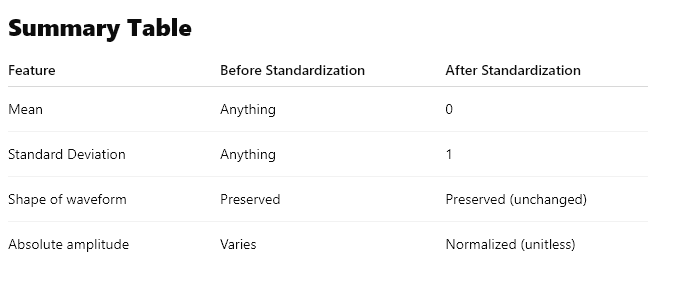




# What Do the Different Levels (A,D1, D2, D3) Mean?

The Wavelet Transform is powerful because it finds these "details" at different scales.
   * Approximation Coefficients (cA): These represent the large, slow hills and valleys you drive over. They are the main, low-frequency trend of the road.

* Detail Coefficients (cD): These represent the small bumps, cracks, and potholes in the road surface. They are the high-frequency vibrations you feel, but they don't change your overall elevation very much.
   * cD1 (Highest Frequency): These are the tiniest, fastest vibrations, like the fine texture of the road's asphalt.

   * cD2: These are slightly larger bumps and dips.

   * cD3: These are even larger bumps that are still considered "details" compared to the main hills.

In EEG analysis, specific brain rhythms like **gamma waves are high-frequency and are captured in these detail coefficients**. By calculating features from each level of detail coefficients, the algorithm can quantify the "amount of wiggliness" at different frequencies, which is a powerful way to detect the subtle changes that occur before a seizure

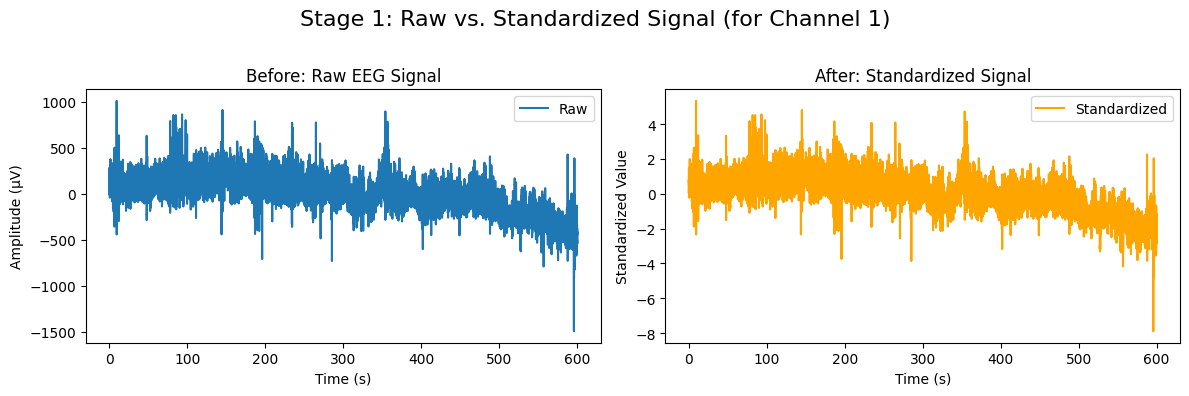

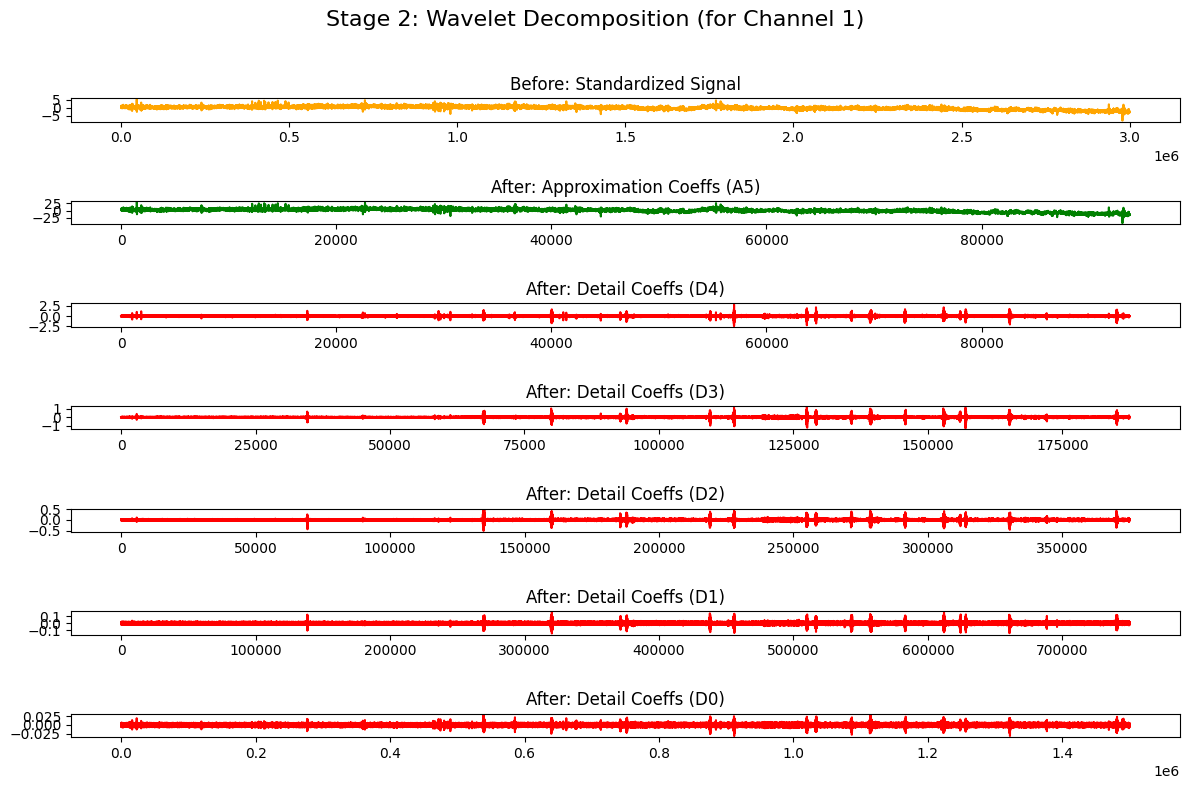

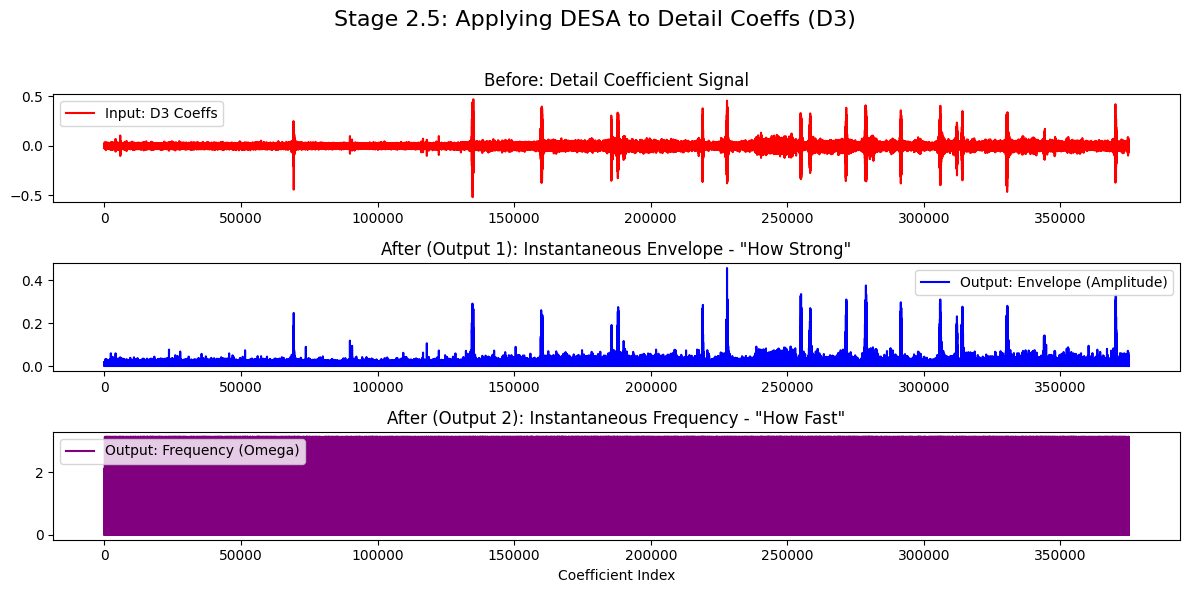

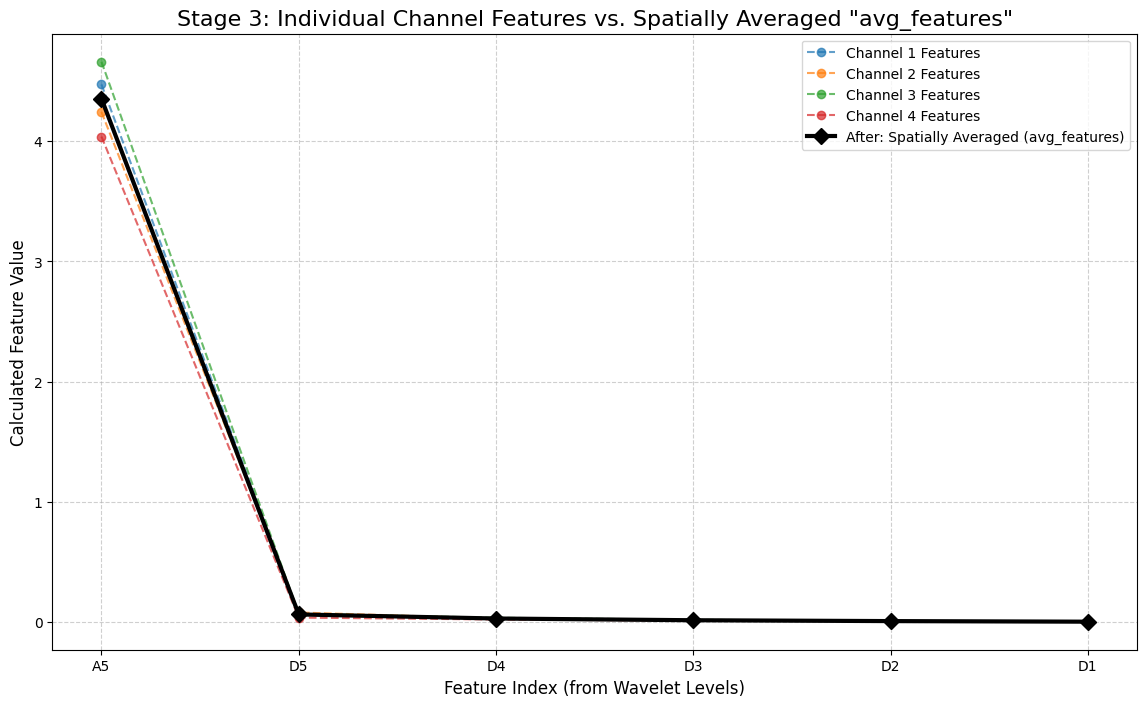

(<matplotlib.legend.Legend at 0x7e7474e31390>, None, None)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pywt
import scipy.io as sio
from scipy.signal import medfilt

# --- Load Multi-Channel Data ---
try:
    filepath = '/content/drive/MyDrive/BCI_Research_Week1/Datasets/AmericanKaggle/Patient_1/Patient_1_test_segment_0027.mat'
    mat_data = sio.loadmat(filepath)
    segment_key = [key for key in mat_data if 'segment' in key and not key.startswith("_")][0]
    segment = mat_data[segment_key]
    multi_channel_signal = segment['data'][0,0]
    sampling_freq = int(segment['sampling_frequency'][0, 0][0, 0])
except FileNotFoundError:
    print("File not found. Using randomly generated data for demonstration.")
    multi_channel_signal = np.random.randn(16, 2000)
    sampling_freq = 400

# --- Functions needed for DESA (copied from the main script for this demonstration) ---
def _teager_kaiser_operator(x: np.ndarray) -> np.ndarray:
    if len(x) < 3: return np.array([])
    return x[1:-1]**2 - x[:-2] * x[2:]

def _desa_algorithm(x: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    if len(x) < 4: return np.array([]), np.array([])
    y = np.diff(x)
    psi_x = _teager_kaiser_operator(x)
    psi_y = _teager_kaiser_operator(y)
    if len(psi_x) == 0 or len(psi_y) == 0: return np.array([]), np.array([])
    n_points = min(len(psi_x), len(psi_y) - 1)
    if n_points <= 0: return np.array([]), np.array([])
    psi_x_sliced, psi_y_sliced, psi_y_next_sliced = psi_x[:n_points], psi_y[:n_points], psi_y[1:n_points + 1]
    omega, amplitude = np.zeros(n_points), np.zeros(n_points)
    denom = 4 * psi_x_sliced
    safe_denom_mask = np.abs(denom) > 1e-10
    arg = np.ones(n_points)
    arg[safe_denom_mask] = 1 - (psi_y_sliced[safe_denom_mask] + psi_y_next_sliced[safe_denom_mask]) / denom[safe_denom_mask]
    omega = np.arccos(np.clip(arg, -1, 1))
    sin_omega = np.sin(omega)
    safe_sin_mask = np.abs(sin_omega) > 1e-10
    safe_mask = safe_denom_mask & safe_sin_mask
    if np.any(safe_mask):
      amplitude[safe_mask] = np.sqrt(np.abs(psi_x_sliced[safe_mask] / (sin_omega[safe_mask]**2)))
    if len(omega) > 5:
        omega = medfilt(omega, kernel_size=5)
        amplitude = medfilt(amplitude, kernel_size=5)
    return amplitude, omega

# --- STAGE 1: RAW VS. STANDARDIZED ---
plt.figure(figsize=(12, 4))
plt.suptitle('Stage 1: Raw vs. Standardized Signal (for Channel 1)', fontsize=16)
raw_channel_1 = multi_channel_signal[0, :]
time = np.arange(len(raw_channel_1)) / sampling_freq
if np.std(raw_channel_1) > 0:
    standardized_channel_1 = (raw_channel_1 - np.mean(raw_channel_1)) / np.std(raw_channel_1)
else:
    standardized_channel_1 = raw_channel_1
plt.subplot(1, 2, 1)
plt.plot(time, raw_channel_1, label='Raw')
plt.title('Before: Raw EEG Signal')
plt.xlabel('Time (s)'), plt.ylabel('Amplitude (µV)'), plt.legend()
plt.subplot(1, 2, 2)
plt.plot(time, standardized_channel_1, label='Standardized', color='orange')
plt.title('After: Standardized Signal')
plt.xlabel('Time (s)'), plt.ylabel('Standardized Value'), plt.legend()
plt.tight_layout(rect=[0, 0, 1, 0.96]), plt.show()

# --- STAGE 2: WAVELET DECOMPOSITION ---
wavelet = 'db6'
level = 5
coeffs = pywt.wavedec(standardized_channel_1, wavelet, level=level)
plt.figure(figsize=(12, 8))
plt.suptitle('Stage 2: Wavelet Decomposition (for Channel 1)', fontsize=16)
plt.subplot(level + 2, 1, 1)
plt.plot(standardized_channel_1, color='orange'), plt.title('Before: Standardized Signal')
for i, c in enumerate(coeffs):
    plt.subplot(level + 2, 1, i + 2)
    plt.plot(c, color='green' if i == 0 else 'red')
    plt.title(f'After: {"Approximation" if i == 0 else "Detail"} Coeffs ({("A" if i == 0 else "D") + str(level - i if i > 0 else level)})')
plt.tight_layout(rect=[0, 0, 1, 0.96]), plt.show()

# --- STAGE 2.5: DESA PROCESSING (for one level) ---
# Let's take one detail level (D3) and see what DESA does to it.
d3_coeffs = coeffs[3]
amplitude, frequency = _desa_algorithm(d3_coeffs)
plt.figure(figsize=(12, 6))
plt.suptitle('Stage 2.5: Applying DESA to Detail Coeffs (D3)', fontsize=16)
plt.subplot(3, 1, 1)
plt.plot(d3_coeffs, label='Input: D3 Coeffs', color='red'), plt.title('Before: Detail Coefficient Signal'), plt.legend()
plt.subplot(3, 1, 2)
plt.plot(amplitude, label='Output: Envelope (Amplitude)', color='blue'), plt.title('After (Output 1): Instantaneous Envelope - "How Strong"'), plt.legend()
plt.subplot(3, 1, 3)
plt.plot(frequency, label='Output: Frequency (Omega)', color='purple'), plt.title('After (Output 2): Instantaneous Frequency - "How Fast"')
plt.xlabel('Coefficient Index'), plt.legend()
plt.tight_layout(rect=[0, 0, 1, 0.96]), plt.show()

# --- STAGE 3: SPATIAL AVERAGING ---
list_of_feature_sets = []
num_channels_to_process = 4
for i in range(num_channels_to_process):
    channel_data = multi_channel_signal[i, :]
    if np.std(channel_data) > 0:
        channel_data = (channel_data - np.mean(channel_data)) / np.std(channel_data)
    c = pywt.wavedec(channel_data, wavelet, level=level)
    feature_set = [np.mean(np.abs(d)) for d in c]
    list_of_feature_sets.append(feature_set)
feature_table = np.array(list_of_feature_sets)
avg_features = np.mean(feature_table, axis=0)
plt.figure(figsize=(14, 8))
plt.title('Stage 3: Individual Channel Features vs. Spatially Averaged "avg_features"', fontsize=16)
feature_indices = np.arange(len(avg_features))
for i in range(num_channels_to_process):
    plt.plot(feature_indices, feature_table[i, :], marker='o', linestyle='--', label=f'Channel {i+1} Features', alpha=0.7)
plt.plot(feature_indices, avg_features, marker='D', linestyle='-', color='black', linewidth=3, markersize=8, label='After: Spatially Averaged (avg_features)')
plt.xlabel('Feature Index (from Wavelet Levels)', fontsize=12)
plt.ylabel('Calculated Feature Value', fontsize=12)
plt.xticks(feature_indices, [f'A{level}'] + [f'D{level-j}' for j in range(level)])
plt.legend(), plt.grid(True, linestyle='--', alpha=0.6), plt.show()

In [ ]:
  def _load_mat_file(self, filepath: str, target_fs: int = 256) -> Tuple[np.ndarray, int]:
      try:
        print(f"--> Attempting to load: {os.path.basename(filepath)}")
        mat_data = sio.loadmat(filepath)
      except Exception as e:
        print(f"Error loading {filepath}: {e}")
        return filepath,None,None
      segment_key = None
      for key in mat_data.keys():
        if 'segment' in key and not key.startswith('_'):
          segment_key = key
          break
        if segment_key is None:
          return None , None
        # Fast normalization
        data = np.nan_to_num(data, nan=0.0, posinf=1e6, neginf=-1e6)


        segment = mat_data[segment_key]
        data = segment['data'][0, 0].astype(np.float32)  # Use float32 for ME (memory efficient)
        original_fs = int(segment['sampling_frequency'][0, 0][0, 0])
        # Downsample if needed
        '''
        What does this do?
          Suppose you have a signal with a sampling frequency (sampling_freq) of 5000 Hz,
          and you want to downsample it to target_fs of 256 Hz.
          data.shape[1] = number of time samples in your original data
          (target_fs / sampling_freq) = proportion by which you want to shrink the signal
        Why multiply?
          If your signal is 5000 samples per second and you want 256 samples per second,
          For every 1 second (5000 samples), you want to keep only 256.
          The ratio is 256/5000 = 0.0512
          So, for any signal of length N, you want the new number of samples to be N * 0.0512
        Why int()?
          The result might not be an integer (e.g., 1250.4 samples).
          You need an integer number of samples, so you cast it to int.
          '''
        if original_fs > target_fs:
          num_samples = int(data.shape[1] * (target_fs / original_fs))
          data = resample(data, num_samples, axis=1)
          current_fs = target_fs
        else:
            current_fs = original_fs
        '''
        Why This Doesn’t Ruin the Data
             Relative changes and patterns (oscillations, spikes, seizures, etc.) in the EEG are preserved—these are what features and classifiers rely on.
             Differences in baseline between electrodes (maybe due to bad contact, scalp differences, sweat, etc.) are removed, which is a good thing.
             Differences in amplitude (e.g., one electrode picking up larger signals due to placement) are also normalized, so no channel “overpowers” the others just due to scaling.

        Why Do It?
            Prevents “big” channels from dominating machine learning.
            Removes arbitrary DC offset (baseline drift).
            Makes features like power, envelope, etc. directly comparable across channels and patients.
            Enables robust patient-aware feature extraction, as in the paper.
            '''

        # Fast preprocessing Normalize and Standardize (Check Example) CHECKLECTUREONTHEMATTER
        # Each channel has zero mean (removes DC offset or baseline drift).
        data = data - np.mean(data, axis=1, keepdims=True)
        #For each channel, computes the standard deviation of its signal (measures amplitude variation) . keepdims=True keeps the array shape compatible for division.
        channel_stds = np.std(data, axis=1, keepdims=True)
        #For any channel with “almost zero” variation (standard deviation < 1e-6), set the std to 1.0 (so you don’t divide by zero or a tiny number and get crazy values).
        channel_stds[channel_stds < 1e-6] = 1.0
        # Each channel now has zero mean and unit standard deviation (amplitude normalized).
        data = data / channel_stds

        return data, current_fs